### Mini Project: AudioMNIST 
Author - Nasrul Huda


Matriculation number - 7896224

In [ ]:
import subprocess
from pathlib import Path

# Import other libraries
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
import torchaudio.transforms as T
from tqdm.auto import tqdm
import json
import collections
import matplotlib.pyplot as plt
import numpy as np

# from helper_functions import accuracy_fn, plot_loss_curves, set_seeds

In [45]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [3]:
DATA_FOLDER = Path("data")  # This will be notebooks/data/ when run from notebook
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

print(f"Data folder: {DATA_FOLDER.absolute()}")


Data folder: /export/home/4huda/group5/notebooks/data


In [4]:
def download_github_folder(repo_url, folder_path, save_folder, branch='main'):
    """
    Download a specific folder from GitHub repository using git sparse-checkout.
    
    Args:
        repo_url: GitHub repo URL (e.g., 'https://github.com/user/repo')
        folder_path: Path to folder in repo (e.g., 'data/datasets')
        save_folder: Local folder to save the downloaded folder
        branch: Branch to download from (default: 'main')
    """
    save_folder = Path(save_folder)
    save_folder.mkdir(parents=True, exist_ok=True)
    
    # Create temporary directory for cloning
    temp_dir = save_folder / ".temp_clone"
    
    try:
        # Clone repository with sparse checkout
        print(f"Cloning repository (sparse checkout)...")
        subprocess.run([
            'git', 'clone', '--filter=blob:none', '--sparse',
            '--depth=1', f'--branch={branch}',
            repo_url, str(temp_dir)
        ], check=True, capture_output=True)
        
        # Configure sparse checkout
        subprocess.run([
            'git', '-C', str(temp_dir), 'sparse-checkout', 'set', folder_path
        ], check=True, capture_output=True)
        
        # Move the folder to save location
        source_folder = temp_dir / folder_path
        if source_folder.exists():
            import shutil
            dest_folder = save_folder / Path(folder_path).name
            if dest_folder.exists():
                shutil.rmtree(dest_folder)
            shutil.move(str(source_folder), str(dest_folder))
            print(f"Downloaded folder to: {dest_folder.absolute()}")
            return dest_folder
        else:
            print(f"Folder {folder_path} not found in repository")
            return None
            
    except subprocess.CalledProcessError as e:
        print(f"Error: {e.stderr.decode()}")
        return None
    finally:
        # Clean up temporary directory
        if temp_dir.exists():
            import shutil
            shutil.rmtree(temp_dir)


In [12]:
# Download AudioMNIST dataset

# Download specific folder
download_github_folder(
    repo_url="https://github.com/soerenab/AudioMNIST",
    folder_path="data", # data folder in the repo 
    save_folder=DATA_FOLDER,
    branch="master"
)

Cloning repository (sparse checkout)...
Downloaded folder to: /export/home/4huda/group5/notebooks/data/data


PosixPath('data/data')

### First Task: Digit Classification

The main goal is to train a neural network that listens to a spoken digit (like `three`) and predicts the number `3`

So it is like MNIST but instead of an image of the number `3`, we have the sound of someone saying the number `3`.

However, Neural Networks do not understand raw sound waves easily, they need numbers representing the important features of the sound. Kind of like how MNIST gives pixel values of the image. 

For this, we turn the audio into something visual, i.e., Spectrograms
- A spectrogram shows time (left -> right), frequency (low -> high on y-axis) and intensity (brightness or color)

This will turn the sound clip into something that looks like an image. Since, we already know that CNNs are great at images, we can use them here.

### Create AudioMNIST Dataset class

#### `AudioMNISTDataset`

A PyTorch Dataset class for loading and preprocessing AudioMNIST audio data.

**Purpose:**
This class provides a convenient interface for loading audio files from the AudioMNIST dataset, handling resampling, channel conversion, and optional transformations (e.g., converting to spectrograms).

**Key Features:**
- Automatically discovers and loads audio files from the dataset directory structure
- Extracts labels from filenames (format: `digit_speaker_repetition.wav`)
- Handles audio resampling to a target sample rate (default: 16kHz)
- Converts stereo audio to mono if needed
- Supports optional transforms for preprocessing (e.g., Mel Spectrogram conversion)

**Parameters:**
- `data_dir` (str or Path): Path to the AudioMNIST data directory containing speaker subdirectories
- `transform` (callable, optional): Transform to apply to audio waveforms (e.g., spectrogram conversion)
- `target_sample_rate` (int, default=16000): Target sample rate for audio resampling

**Methods:**
- `__len__()`: Returns the total number of audio samples in the dataset
- `__getitem__(idx)`: Returns a tuple of (waveform, label) for the given index

**Returns:**
- `waveform` (torch.Tensor): Preprocessed audio waveform tensor
- `label` (int): Digit label (0-9) extracted from the filename

In [3]:
class AudioMNISTDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_sample_rate=16000):
        """
        Args:
           data_dir: Path to the data directory 
           transform: Optional transform to be applied on the audio data
           target_sample_rate: Target sample rate for audio data (default: 16kHz)
        """
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.target_sample_rate = target_sample_rate
        self.audio_files = []
        self.labels = []

        # Collect all audio files and their labels
        for speaker_dir in sorted(self.data_dir.glob('[0-9]*')):
            if speaker_dir.is_dir():
                for audio_file in speaker_dir.glob('*.wav'):
                    # Extract digit from filename (format: digit_speaker_repetition.wav)
                    digit = int(audio_file.stem.split('_')[0])
                    self.audio_files.append(audio_file)
                    self.labels.append(digit)

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        label = self.labels[idx]

        # Load audio file
        waveform, sample_rate = torchaudio.load(str(audio_path))

        # Resample if necessary
        if sample_rate != self.target_sample_rate:
            resampler = T.Resample(sample_rate, self.target_sample_rate)
            waveform = resampler(waveform)

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Apply transform (e.g., convert to spectrogram)
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label

### Audio Preprocessing: Mel Spectrogram
#### Why Mel Spectrogram?
Mel spectrograms are chosen as the audio representation for this digit classification task for several key reasons:
1. Perceptual Relevance: The Mel scale approximates human auditory perception, where humans are more sensitive to changes in lower frequencies than higher frequencies. This makes it ideal for speech and digit recognition tasks.
2. Dimensionality Reduction: Converting raw waveforms to Mel spectrograms reduces the data dimensionality while preserving important frequency information, making it more efficient for neural network processing.
3. Standard Practice: Mel spectrograms are widely used in speech recognition and audio classification tasks, providing a proven baseline representation.
4. Frequency Information: Unlike raw waveforms, spectrograms explicitly capture frequency content over time, which is crucial for distinguishing between different spoken digits (0-9).
#### Parameter Selection Rationale
`sample_rate=16000`
- Matches the target sample rate of the AudioMNIST dataset after resampling
- 16 kHz is sufficient for speech signals (human speech typically ranges from 85 Hz to 8 kHz)
- Balances quality with computational efficiency

`n_fft=1024`
- Determines the frequency resolution of the spectrogram
- 1024 provides good frequency resolution (~15.6 Hz per bin at 16 kHz)
- Common choice that balances resolution with computational cost
- Higher values (2048, 4096) would increase resolution but also increase memory usage

`win_length=1024`
- Window length for the FFT analysis (matches `n_fft`)
- Ensures no zero-padding is needed, maximizing frequency resolution
- ~64 ms window duration at 16 kHz, which captures sufficient temporal context for speech

`hop_length=256`
- Step size between consecutive windows (25% of window length)
- Provides good temporal resolution (~16 ms between frames)
- Creates ~75% overlap between windows, ensuring smooth transitions
- Smaller values increase temporal resolution but also increase computational cost

`n_mels=64`
- Number of Mel filter banks
- 64 filters provide good frequency granularity for speech recognition
- Balances detail with model complexity
- Common choice for speech tasks (typically ranges from 32-128)

`f_min=0`
- Minimum frequency included in the Mel scale
- Starts from DC component (0 Hz)
- Captures all frequency content in the signal

`f_max=8000`
- Maximum frequency included in the Mel scale
- Set to half the sample rate (Nyquist frequency)
- Captures the full frequency range of the resampled audio
- Human speech energy is primarily below 8 kHz, making this an appropriate upper bound

In [4]:
# Create transform to convert audio to Mel Spectrogram
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=16000, # 16kHz is the sample rate of the AudioMNIST dataset
    n_fft=1024, # 1024 is the number of FFT bins
    win_length=1024, # 1024 is the window length
    hop_length=256, # 256 is the hop length
    n_mels=64, # 64 is the number of Mel filters
    f_min=0, # 0 is the minimum frequency
    f_max=8000 # 8000 is the maximum frequency
)

# Add Amplitude to DB Conversion
amplitude_to_db = T.AmplitudeToDB()

In [5]:
# Load the dataset
DATA_DIR = Path("data/data")
dataset = AudioMNISTDataset(
    DATA_DIR, 
    transform=mel_spectrogram_transform,
    target_sample_rate=16000
)

print(f"Total samples: {len(dataset)}")
print(f"Sample shape: {dataset[0][0].shape}")
print(f"Label: {dataset[0][1]}")

Total samples: 30000
Sample shape: torch.Size([1, 64, 36])
Label: 8


### Dataset Structure Analysis

The AudioMNIST dataset has a well-balanced structure:
- **Total samples**: 30,000 audio files
- **Speakers**: 60 (numbered 01-60)
- **Digits**: 10 (0-9)
- **Repetitions**: 50 per digit per speaker
- **Structure**: 60 speakers × 10 digits × 50 repetitions = 30,000 samples

This balanced structure ensures:
1. No class imbalance issues (each digit has exactly 3,000 samples)
2. Rich speaker diversity (60 different voices)
3. Multiple examples per speaker-digit combination (robustness to variations)


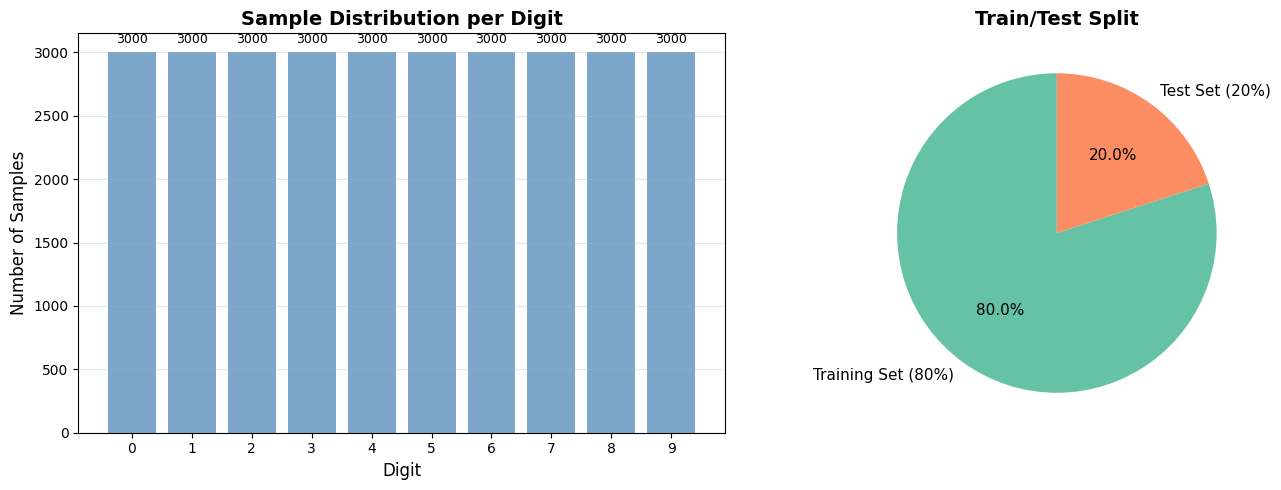


Dataset Statistics:
  Total samples: 30,000
  Training samples: 24,000
  Test samples: 6,000
  Samples per digit: 3,000
  Number of speakers: 60
  Samples per speaker: 500


In [47]:
# Calculate statistics from the dataset
label_counts_local = collections.Counter(dataset.labels)
num_speakers_local = len([d for d in DATA_DIR.glob('[0-9]*') if d.is_dir()])
train_size_local = int(0.8 * len(dataset))
test_size_local = len(dataset) - train_size_local

# Create visualization of dataset structure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Samples per digit
digits = list(range(10))
samples_per_digit = [label_counts_local[d] for d in digits]

bars1 = axes[0].bar(digits, samples_per_digit, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Digit', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Sample Distribution per Digit', fontsize=14, fontweight='bold')
axes[0].set_xticks(digits)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Plot 2: Dataset composition pie chart
composition = {
    'Training Set (80%)': train_size_local,
    'Test Set (20%)': test_size_local
}

colors_pie = ['#66c2a5', '#fc8d62']
axes[1].pie(composition.values(), labels=composition.keys(), autopct='%1.1f%%',
           colors=colors_pie, startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Train/Test Split', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDataset Statistics:")
print(f"  Total samples: {len(dataset):,}")
print(f"  Training samples: {train_size_local:,}")
print(f"  Test samples: {test_size_local:,}")
print(f"  Samples per digit: {samples_per_digit[0]:,}")
print(f"  Number of speakers: {num_speakers_local}")
print(f"  Samples per speaker: {len(dataset) // num_speakers_local}")


### Audio to Spectrogram Transformation

To better understand our preprocessing pipeline, let's visualize how raw audio waveforms are transformed into Mel spectrograms. This transformation is crucial for making audio data suitable for neural network processing.


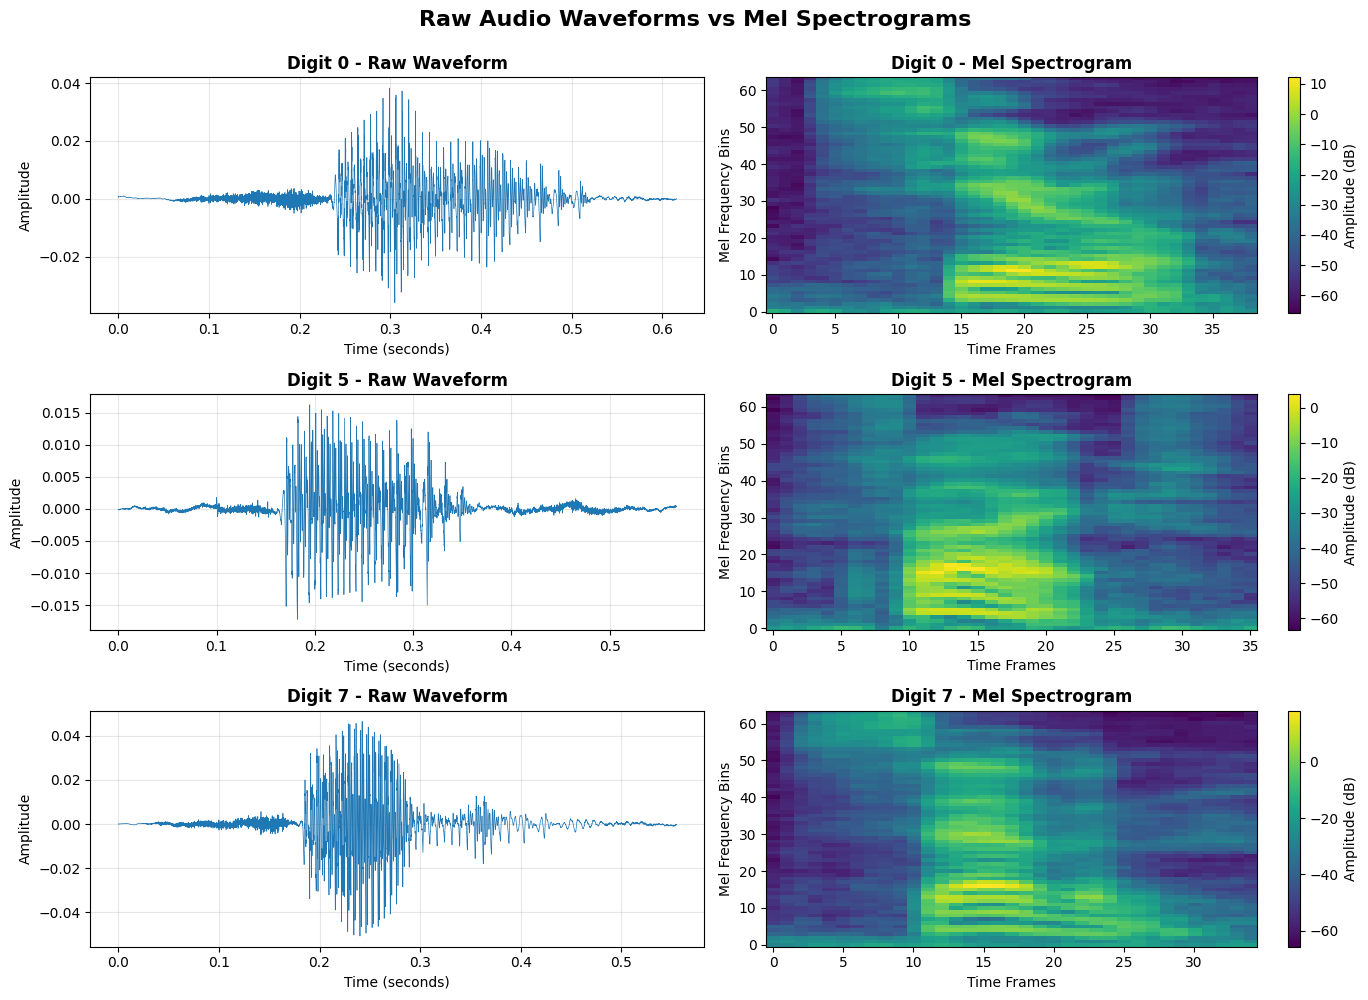

Key Observations:
  • Left column: Raw waveforms show amplitude variations over time
  • Right column: Spectrograms show frequency content over time
  • Spectrograms reveal patterns not visible in raw waveforms
  • Bright regions = high energy at specific frequencies
  • Dark regions = low energy
  • Neural networks can learn from these visual patterns


In [48]:
# Compare raw waveform with its spectrogram for 3 different digits
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

digits_to_show = [0, 5, 7]

for idx, digit in enumerate(digits_to_show):
    # Find a sample for this digit
    sample_idx = None
    for i in range(len(dataset.audio_files)):
        if dataset.labels[i] == digit:
            sample_idx = i
            break
    
    # Load raw waveform (without transform)
    audio_path = dataset.audio_files[sample_idx]
    waveform, sample_rate = torchaudio.load(str(audio_path))
    
    # Resample if needed
    if sample_rate != 16000:
        resampler = T.Resample(sample_rate, 16000)
        waveform = resampler(waveform)
    
    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Get spectrogram
    spectrogram = mel_spectrogram_transform(waveform)
    spectrogram_db = amplitude_to_db(spectrogram)
    
    # Plot waveform
    ax_wave = axes[idx, 0]
    time_axis = np.arange(waveform.shape[1]) / 16000  # Convert to seconds
    ax_wave.plot(time_axis, waveform[0].numpy(), linewidth=0.5)
    ax_wave.set_title(f'Digit {digit} - Raw Waveform', fontsize=12, fontweight='bold')
    ax_wave.set_xlabel('Time (seconds)', fontsize=10)
    ax_wave.set_ylabel('Amplitude', fontsize=10)
    ax_wave.grid(alpha=0.3)
    
    # Plot spectrogram
    ax_spec = axes[idx, 1]
    im = ax_spec.imshow(spectrogram_db[0].numpy(), 
                        aspect='auto', 
                        origin='lower',
                        cmap='viridis')
    ax_spec.set_title(f'Digit {digit} - Mel Spectrogram', fontsize=12, fontweight='bold')
    ax_spec.set_xlabel('Time Frames', fontsize=10)
    ax_spec.set_ylabel('Mel Frequency Bins', fontsize=10)
    plt.colorbar(im, ax=ax_spec, label='Amplitude (dB)')

plt.suptitle('Raw Audio Waveforms vs Mel Spectrograms', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Key Observations:")
print("  • Left column: Raw waveforms show amplitude variations over time")
print("  • Right column: Spectrograms show frequency content over time")
print("  • Spectrograms reveal patterns not visible in raw waveforms")
print("  • Bright regions = high energy at specific frequencies")
print("  • Dark regions = low energy")
print("  • Neural networks can learn from these visual patterns")


In [6]:
# Count the number of speakers in the dataset
# Speakers are represented by directories in the data folder
speaker_dirs = sorted([d for d in DATA_DIR.glob('[0-9]*') if d.is_dir()])
num_speakers = len(speaker_dirs)
print(f"Number of speakers: {num_speakers}")


Number of speakers: 60


### Visualizing Mel Spectrograms: Same Digit, Different Speakers

To understand how different speakers pronounce the same digit, we'll visualize mel spectrograms for the same digit across multiple speakers. This helps us see:
- **Inter-speaker variability**: How much variation exists between different speakers
- **Common patterns**: What acoustic features remain consistent for a digit
- **Speaker characteristics**: Individual voice characteristics (pitch, tone, duration)


In [12]:
# Function to get speaker information from the dataset
def get_samples_by_digit_and_speaker(dataset, digit, num_speakers=5):
    """
    Get samples of a specific digit from different speakers.
    
    Args:
        dataset: AudioMNISTDataset instance
        digit: The digit to find (0-9)
        num_speakers: Number of different speakers to get
        
    Returns:
        List of tuples: [(spectrogram, label, speaker_id, audio_path), ...]
    """
    samples = []
    speakers_found = set()
    
    for idx in range(len(dataset)):
        audio_path = dataset.audio_files[idx]
        label = dataset.labels[idx]
        
        # Extract speaker ID from filename (format: digit_speaker_repetition.wav)
        filename_parts = audio_path.stem.split('_')
        speaker_id = filename_parts[1]
        
        # Check if this is the digit we want and from a new speaker
        if label == digit and speaker_id not in speakers_found:
            spectrogram, _ = dataset[idx]
            samples.append((spectrogram, label, speaker_id, audio_path))
            speakers_found.add(speaker_id)
            
            # Stop when we have enough speakers
            if len(samples) >= num_speakers:
                break
    
    return samples


In [14]:
import matplotlib.pyplot as plt

def plot_spectrograms_same_digit(samples, digit, amplitude_to_db):
    """
    Plot mel spectrograms for the same digit spoken by different speakers.
    
    Args:
        samples: List of tuples (spectrogram, label, speaker_id, audio_path)
        digit: The digit being visualized
        amplitude_to_db: Transform to convert amplitude to dB scale
    """
    num_samples = len(samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))
    
    # Handle case where num_samples is 1
    if num_samples == 1:
        axes = [axes]
    
    for idx, (spectrogram, label, speaker_id, audio_path) in enumerate(samples):
        # Convert to dB scale for better visualization
        spec_db = amplitude_to_db(spectrogram)
        
        # Plot
        ax = axes[idx]
        im = ax.imshow(spec_db[0].numpy(), 
                       aspect='auto', 
                       origin='lower',
                       cmap='viridis')
        ax.set_title(f'Speaker {speaker_id}\nDigit: {digit}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time Frames', fontsize=10)
        ax.set_ylabel('Mel Frequency Bins', fontsize=10)
        
        # Add colorbar for each subplot
        plt.colorbar(im, ax=ax, label='Amplitude (dB)')
    
    plt.suptitle(f'Mel Spectrograms for Digit "{digit}" - Different Speakers', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


Found 5 samples for digit 0 from different speakers


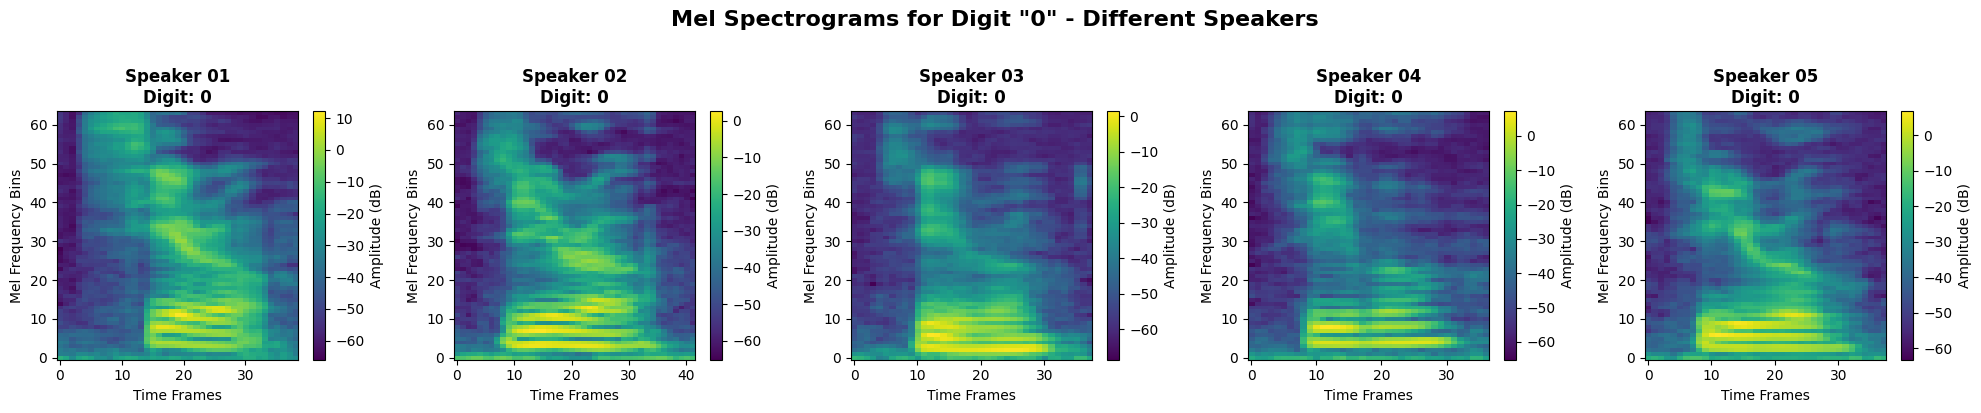

In [15]:
# Visualize digit 0 spoken by 5 different speakers
digit_to_visualize = 0
num_speakers = 5

samples = get_samples_by_digit_and_speaker(dataset, digit_to_visualize, num_speakers)
print(f"Found {len(samples)} samples for digit {digit_to_visualize} from different speakers")

plot_spectrograms_same_digit(samples, digit_to_visualize, amplitude_to_db)


Found 5 samples for digit 5 from different speakers


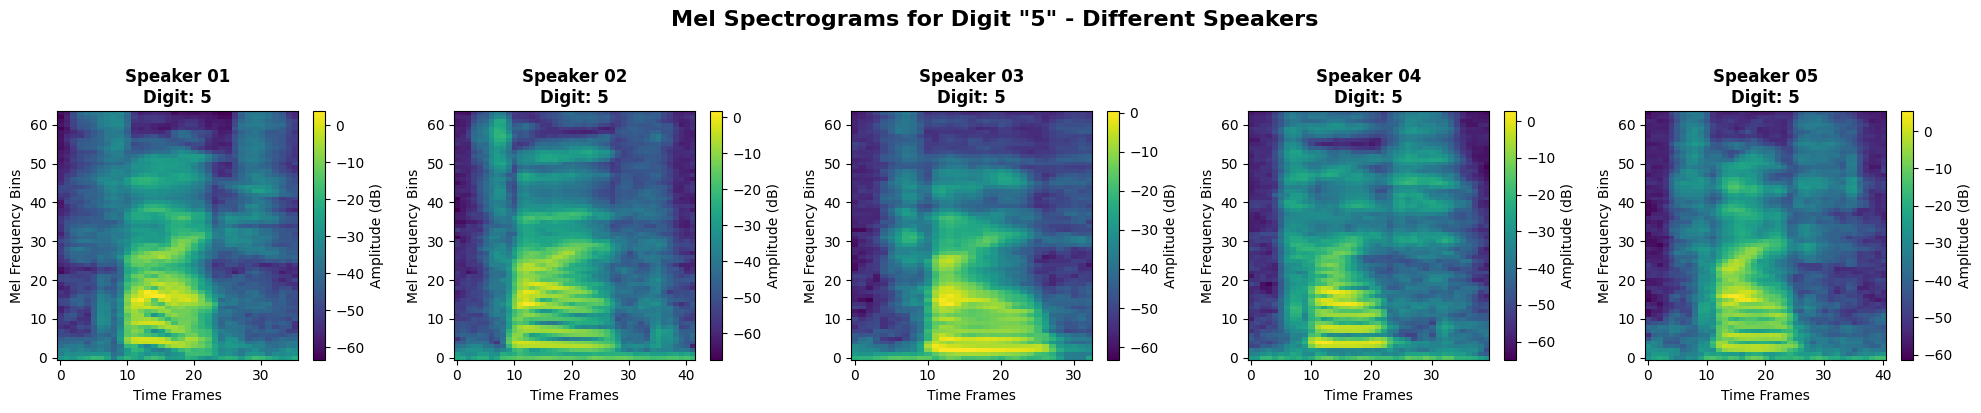

In [16]:
# Visualize digit 5 spoken by 5 different speakers
digit_to_visualize = 5
num_speakers = 5

samples = get_samples_by_digit_and_speaker(dataset, digit_to_visualize, num_speakers)
print(f"Found {len(samples)} samples for digit {digit_to_visualize} from different speakers")

plot_spectrograms_same_digit(samples, digit_to_visualize, amplitude_to_db)


Found 6 samples for digit 7 from different speakers


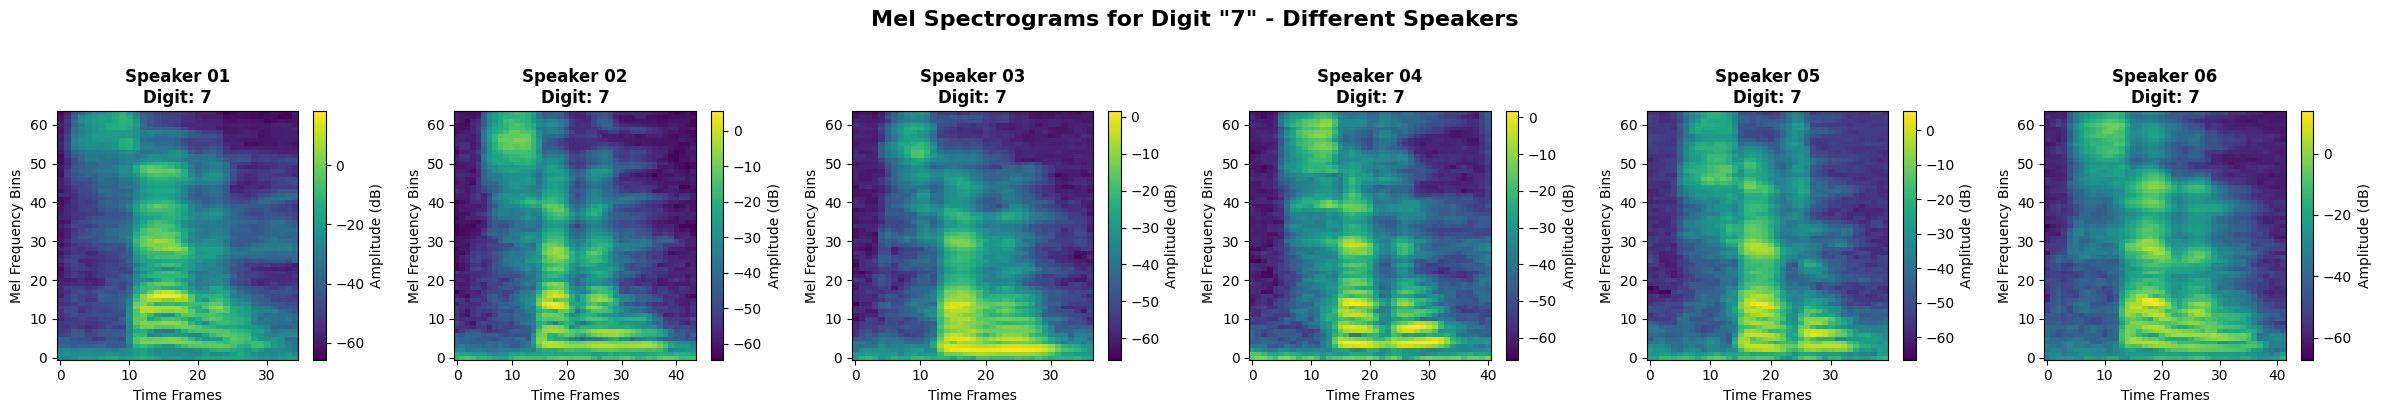

In [17]:
# Visualize digit 7 spoken by 6 different speakers
digit_to_visualize = 7
num_speakers = 6

samples = get_samples_by_digit_and_speaker(dataset, digit_to_visualize, num_speakers)
print(f"Found {len(samples)} samples for digit {digit_to_visualize} from different speakers")

plot_spectrograms_same_digit(samples, digit_to_visualize, amplitude_to_db)


### Grid Visualization: Multiple Digits, Multiple Speakers

Now let's create a comprehensive grid showing multiple digits (rows) and multiple speakers (columns). This gives us a complete view of both inter-digit and inter-speaker variability.


In [18]:
def plot_spectrogram_grid(dataset, digits, num_speakers_per_digit, amplitude_to_db):
    """
    Plot a grid of mel spectrograms with digits as rows and speakers as columns.
    
    Args:
        dataset: AudioMNISTDataset instance
        digits: List of digits to visualize
        num_speakers_per_digit: Number of speakers to show for each digit
        amplitude_to_db: Transform to convert amplitude to dB scale
    """
    num_digits = len(digits)
    
    fig, axes = plt.subplots(num_digits, num_speakers_per_digit, 
                             figsize=(3.5 * num_speakers_per_digit, 3 * num_digits))
    
    # Handle case where we have only one row or column
    if num_digits == 1:
        axes = axes.reshape(1, -1)
    elif num_speakers_per_digit == 1:
        axes = axes.reshape(-1, 1)
    
    for digit_idx, digit in enumerate(digits):
        # Get samples for this digit
        samples = get_samples_by_digit_and_speaker(dataset, digit, num_speakers_per_digit)
        
        for speaker_idx, (spectrogram, label, speaker_id, audio_path) in enumerate(samples):
            # Convert to dB scale
            spec_db = amplitude_to_db(spectrogram)
            
            # Plot
            ax = axes[digit_idx, speaker_idx]
            im = ax.imshow(spec_db[0].numpy(), 
                          aspect='auto', 
                          origin='lower',
                          cmap='viridis')
            
            # Add titles for first row (speaker IDs)
            if digit_idx == 0:
                ax.set_title(f'Speaker {speaker_id}', fontsize=10, fontweight='bold')
            
            # Add y-labels for first column (digit labels)
            if speaker_idx == 0:
                ax.set_ylabel(f'Digit {digit}', fontsize=11, fontweight='bold')
            
            # Only show x-label on bottom row
            if digit_idx == num_digits - 1:
                ax.set_xlabel('Time', fontsize=9)
            else:
                ax.set_xticks([])
            
            # Only show y-ticks on first column
            if speaker_idx != 0:
                ax.set_yticks([])
    
    plt.suptitle('Mel Spectrograms: Multiple Digits × Multiple Speakers', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


Creating grid visualization for digits [0, 3, 7, 9]
Showing 4 different speakers for each digit


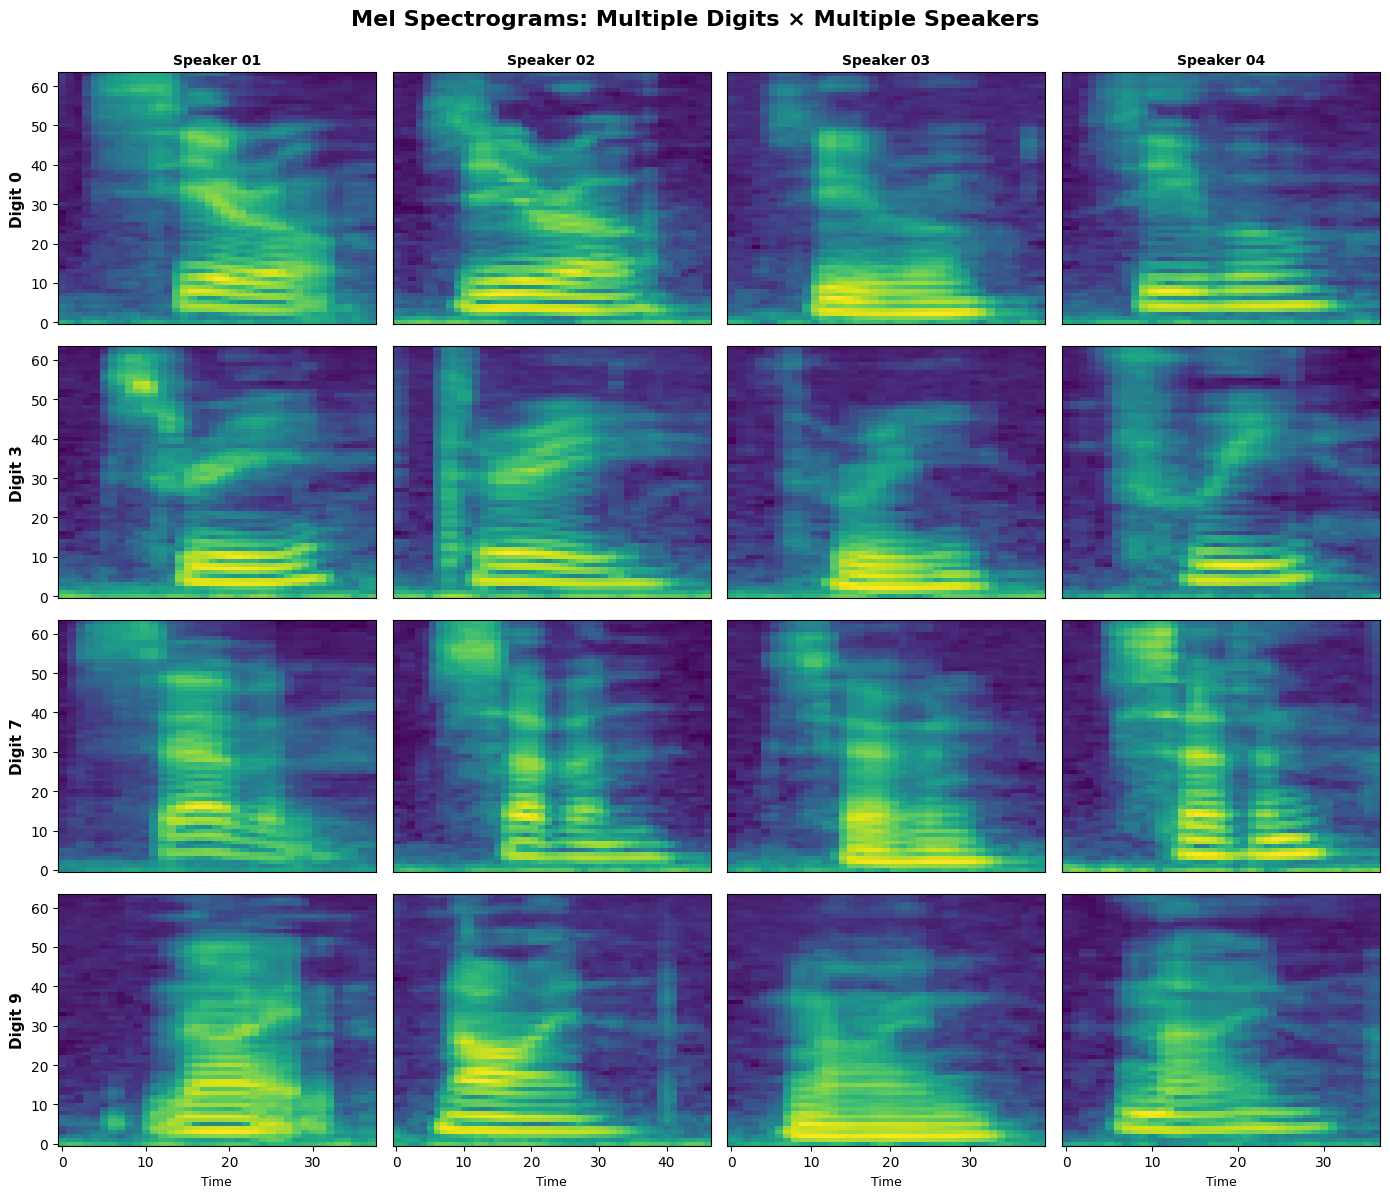

In [19]:
# Visualize a grid: 4 digits × 4 speakers
digits_to_visualize = [0, 3, 7, 9]
num_speakers_per_digit = 4

print(f"Creating grid visualization for digits {digits_to_visualize}")
print(f"Showing {num_speakers_per_digit} different speakers for each digit")

plot_spectrogram_grid(dataset, digits_to_visualize, num_speakers_per_digit, amplitude_to_db)


Creating comprehensive grid visualization for all digits 0-9
Showing 3 different speakers for each digit


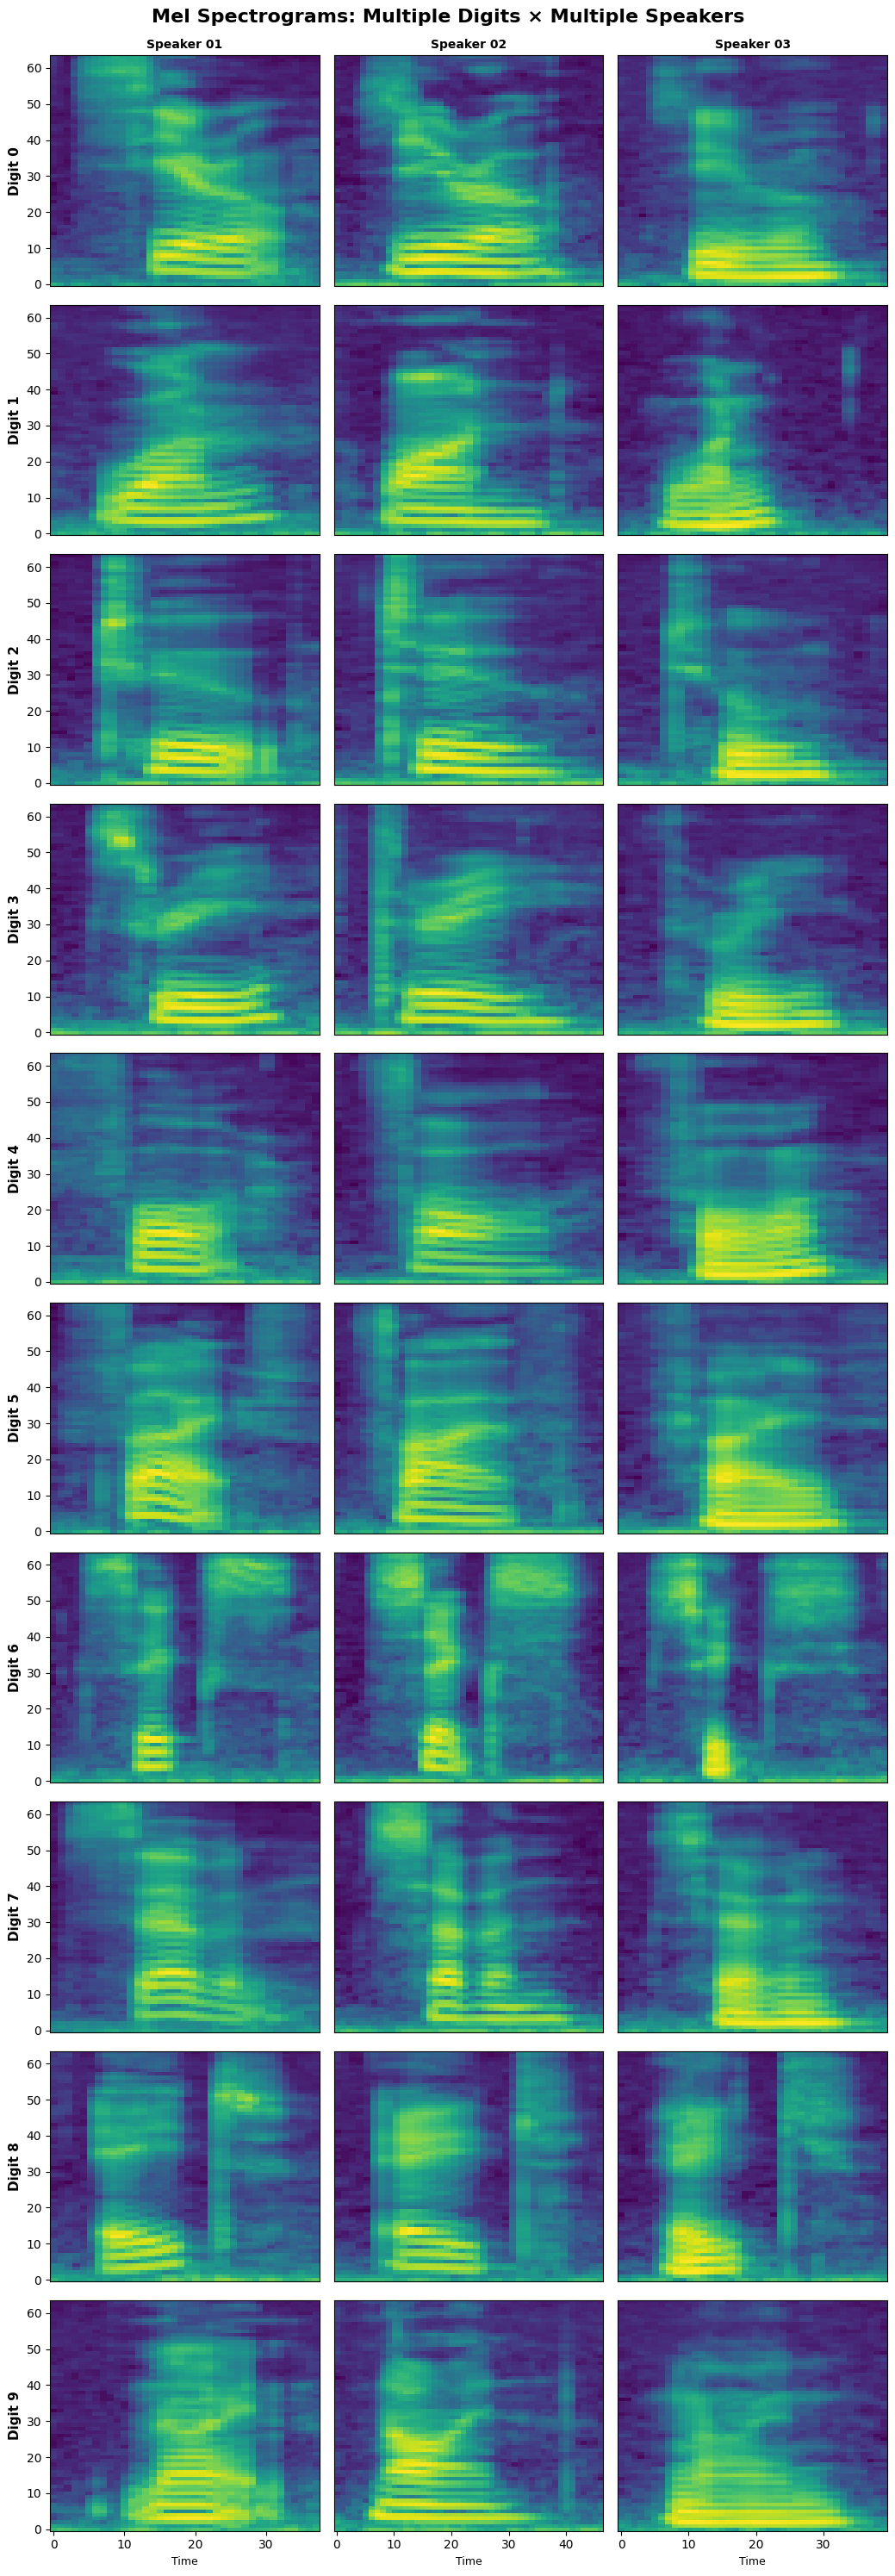

In [20]:
# Comprehensive visualization: All 10 digits × 3 speakers each
digits_to_visualize = list(range(10))  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_speakers_per_digit = 3

print(f"Creating comprehensive grid visualization for all digits 0-9")
print(f"Showing {num_speakers_per_digit} different speakers for each digit")

plot_spectrogram_grid(dataset, digits_to_visualize, num_speakers_per_digit, amplitude_to_db)


### Same Speaker, Different Digits

We can also look at the opposite perspective: how does one speaker's voice look when pronouncing different digits? This helps us understand how much variability comes from the digit itself vs. the speaker's voice characteristics.


In [21]:
def get_samples_by_speaker(dataset, speaker_id, digits=None):
    """
    Get samples from a specific speaker for different digits.
    
    Args:
        dataset: AudioMNISTDataset instance
        speaker_id: The speaker ID to find (as string)
        digits: List of digits to get (default: all digits 0-9)
        
    Returns:
        List of tuples: [(spectrogram, label, speaker_id, audio_path), ...]
    """
    if digits is None:
        digits = list(range(10))
    
    samples = []
    digits_found = set()
    
    for idx in range(len(dataset)):
        audio_path = dataset.audio_files[idx]
        label = dataset.labels[idx]
        
        # Extract speaker ID from filename (format: digit_speaker_repetition.wav)
        filename_parts = audio_path.stem.split('_')
        file_speaker_id = filename_parts[1]
        
        # Check if this is from the target speaker and a digit we want
        if file_speaker_id == speaker_id and label in digits and label not in digits_found:
            spectrogram, _ = dataset[idx]
            samples.append((spectrogram, label, file_speaker_id, audio_path))
            digits_found.add(label)
            
            # Stop when we have all digits
            if len(samples) >= len(digits):
                break
    
    # Sort by digit for consistent visualization
    samples.sort(key=lambda x: x[1])
    return samples


In [23]:
def plot_spectrograms_same_speaker(samples, speaker_id, amplitude_to_db):
    """
    Plot mel spectrograms for different digits spoken by the same speaker.
    
    Args:
        samples: List of tuples (spectrogram, label, speaker_id, audio_path)
        speaker_id: The speaker ID being visualized
        amplitude_to_db: Transform to convert amplitude to dB scale
    """
    num_samples = len(samples)
    
    # Create a grid layout - 2 rows for up to 10 digits
    if num_samples <= 5:
        rows, cols = 1, num_samples
        figsize = (3.5 * num_samples, 4)
    else:
        rows, cols = 2, (num_samples + 1) // 2
        figsize = (3.5 * cols, 4 * rows)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten axes array for easier iteration
    if num_samples == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if num_samples > 1 else [axes]
    
    for idx, (spectrogram, label, spk_id, audio_path) in enumerate(samples):
        # Convert to dB scale
        spec_db = amplitude_to_db(spectrogram)
        
        # Plot
        ax = axes[idx]
        im = ax.imshow(spec_db[0].numpy(), 
                       aspect='auto', 
                       origin='lower',
                       cmap='viridis')
        ax.set_title(f'Digit: {label}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time Frames', fontsize=10)
        ax.set_ylabel('Mel Frequency Bins', fontsize=10)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label='Amplitude (dB)')
    
    # Hide unused subplots if any
    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Speaker {speaker_id} - Different Digits', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()


Example speaker ID format: 01

Visualizing speaker '01' saying all digits 0-9...
Found 10 digit samples for speaker 01


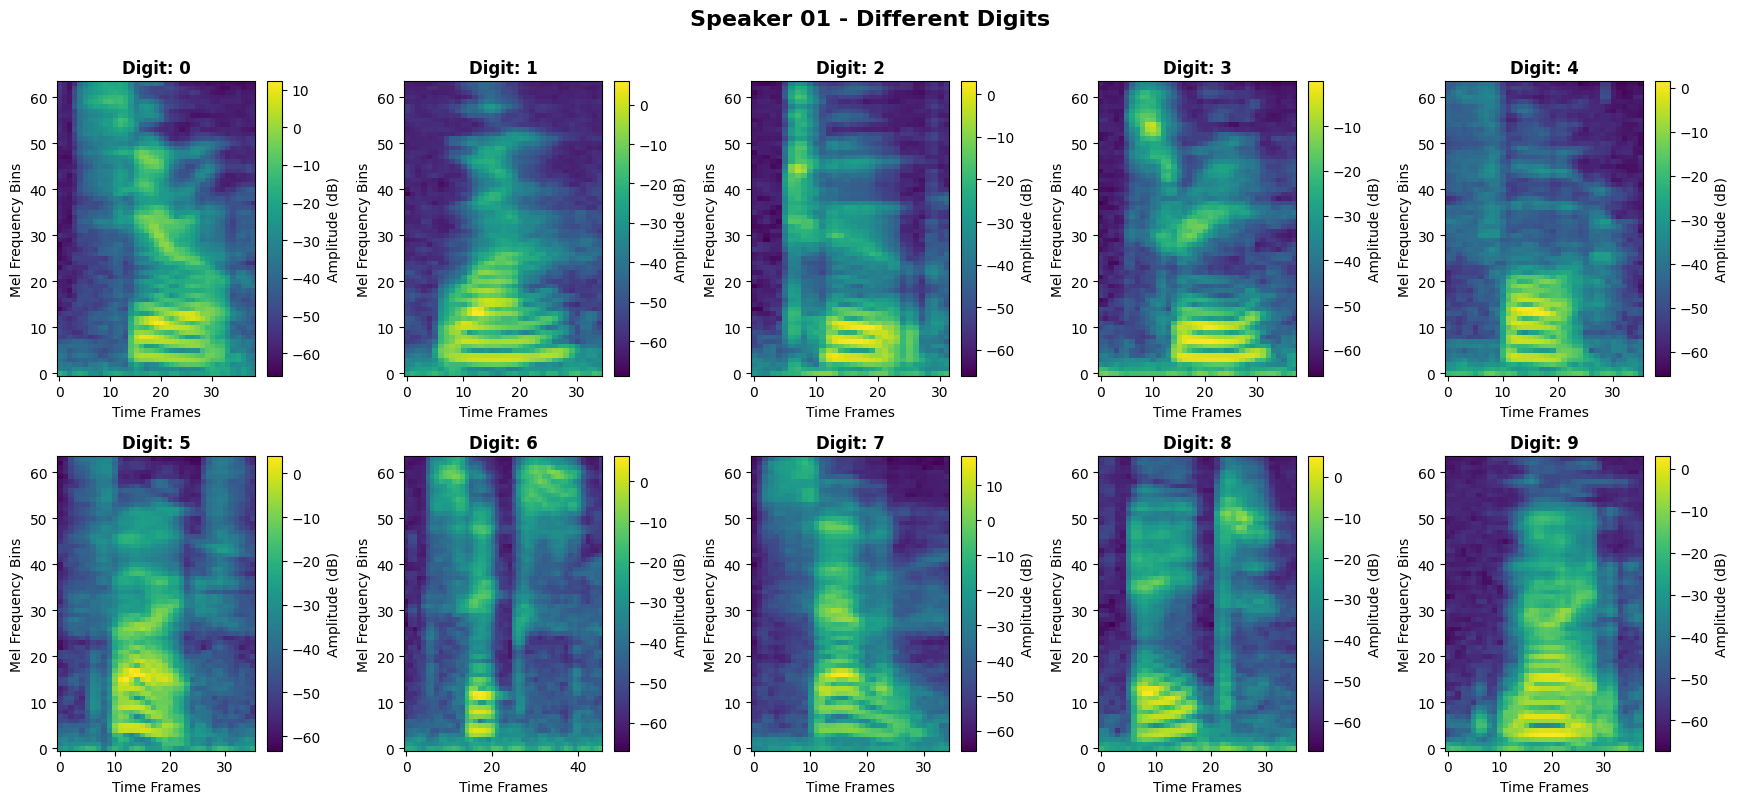

In [24]:
# Visualize one speaker saying all 10 digits
# First, let's find what speaker IDs are available
sample_audio_file = dataset.audio_files[0]
speaker_id_example = sample_audio_file.stem.split('_')[1]

print(f"Example speaker ID format: {speaker_id_example}")
print(f"\nVisualizing speaker '01' saying all digits 0-9...")

speaker_id_to_visualize = "01"
samples = get_samples_by_speaker(dataset, speaker_id_to_visualize, digits=list(range(10)))

print(f"Found {len(samples)} digit samples for speaker {speaker_id_to_visualize}")
plot_spectrograms_same_speaker(samples, speaker_id_to_visualize, amplitude_to_db)


Found 10 digit samples for speaker 28


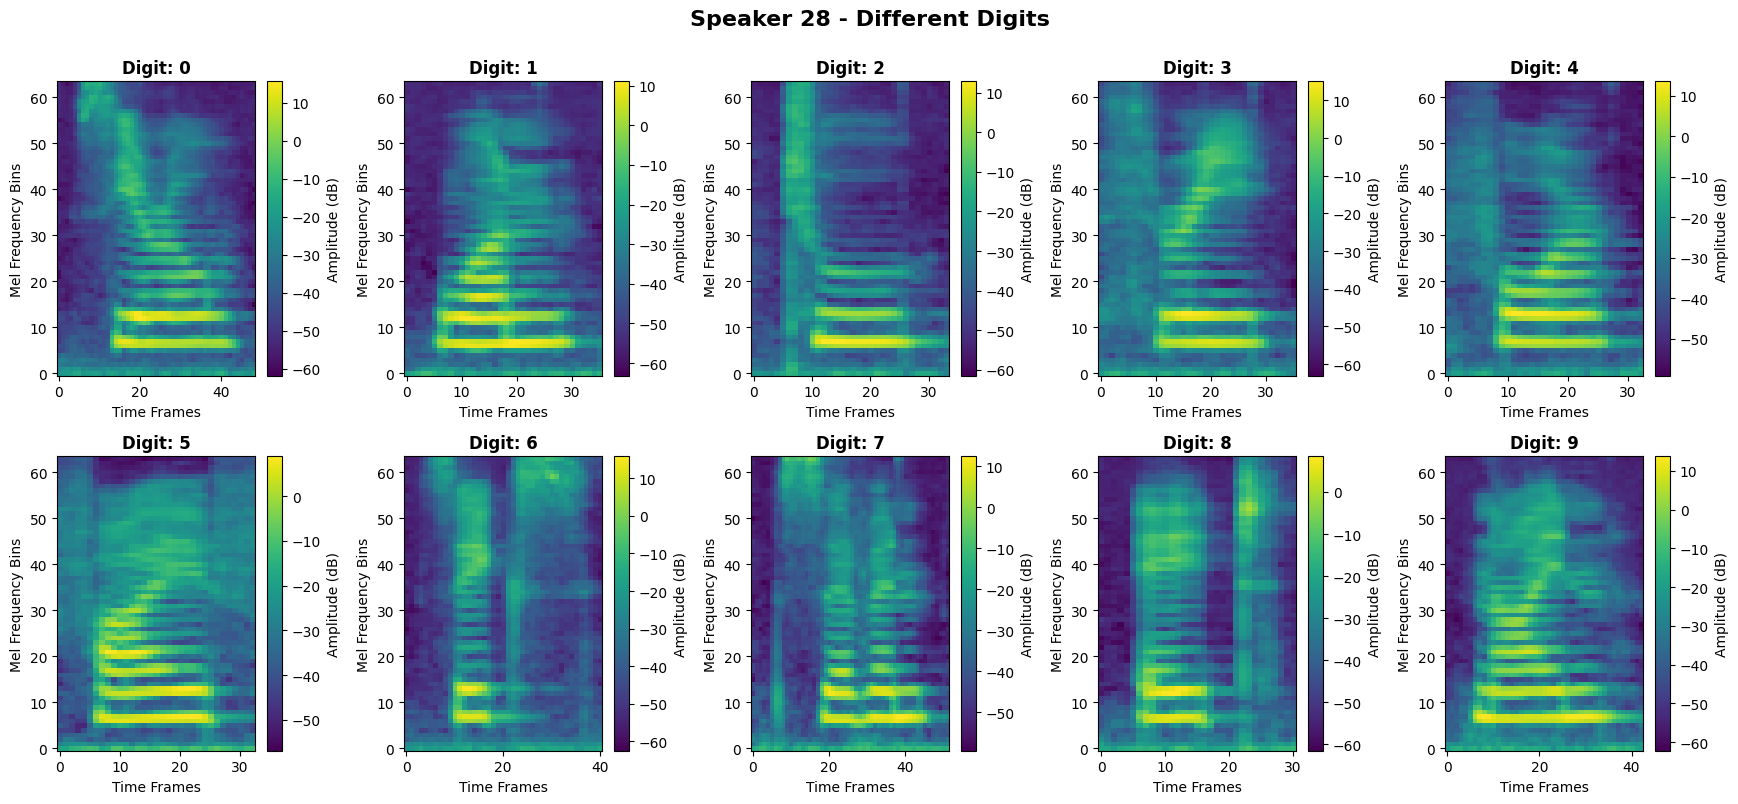

In [25]:
# Visualize another speaker (speaker 28) saying all 10 digits for comparison
speaker_id_to_visualize = "28"
samples = get_samples_by_speaker(dataset, speaker_id_to_visualize, digits=list(range(10)))

print(f"Found {len(samples)} digit samples for speaker {speaker_id_to_visualize}")
plot_spectrograms_same_speaker(samples, speaker_id_to_visualize, amplitude_to_db)


### Key Observations from Spectrogram Visualizations

From these mel spectrogram visualizations, we can observe several important patterns:

#### 1. **Inter-Speaker Variability**
- Different speakers show variation in:
  - **Duration**: Some speakers pronounce digits faster/slower (visible as narrower/wider spectrograms)
  - **Pitch**: Vertical patterns show different fundamental frequencies (men typically have lower pitch, women higher)
  - **Energy distribution**: Some speakers have more energy in higher frequencies, others in lower frequencies
  - **Articulation style**: The way spectrograms evolve over time varies between speakers

#### 2. **Consistent Digit Patterns**
- Despite speaker variability, each digit maintains characteristic patterns:
  - **Vowel sounds**: Show up as horizontal bands of energy at specific frequencies
  - **Consonants**: Appear as rapid transitions or gaps in the spectrogram
  - **Duration patterns**: Some digits (like "seven") are naturally longer than others (like "oh")
  
#### 3. **What Makes Classification Possible**
- Even with speaker variability, neural networks can learn:
  - **Invariant features**: Patterns that remain consistent across speakers for each digit
  - **Temporal structure**: How the sound evolves over time (transitions between phonemes)
  - **Frequency patterns**: Characteristic formant structures for each digit's vowel sounds

#### 4. **Why Different Architectures Work**
- **MLPs**: Can learn average energy patterns but miss temporal relationships
- **CNNs**: Capture local frequency-time patterns that are shift-invariant
- **LSTMs**: Model the sequential evolution of speech sounds over time

These visualizations help us understand why audio classification is challenging (high variability) but also feasible (consistent patterns exist).


In [ ]:
# Diagnostic: Check all unique labels in the dataset
import collections

print("=== Label Analysis ===")
print(f"Total samples: {len(dataset)}")
print(f"Unique labels: {sorted(set(dataset.labels))}")
print(f"Number of unique labels: {len(set(dataset.labels))}")

label_counts = collections.Counter(dataset.labels)
print("\nLabel distribution:")
for digit in sorted(label_counts.keys()):
    print(f"  Digit {digit}: {label_counts[digit]} samples")

# Check if all digits 0-9 are present
expected_digits = set(range(10))
actual_digits = set(dataset.labels)
missing_digits = expected_digits - actual_digits
if missing_digits:
    print(f"\nWARNING: Missing digits: {sorted(missing_digits)}")
else:
    print("\nAll digits 0-9 are present in the dataset!")


=== Label Analysis ===
Total samples: 30000
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of unique labels: 10
Number of speakers: 3000.0

Label distribution:
  Digit 0: 3000 samples
  Digit 1: 3000 samples
  Digit 2: 3000 samples
  Digit 3: 3000 samples
  Digit 4: 3000 samples
  Digit 5: 3000 samples
  Digit 6: 3000 samples
  Digit 7: 3000 samples
  Digit 8: 3000 samples
  Digit 9: 3000 samples

All digits 0-9 are present in the dataset!


In [6]:
# Custom collate function to handle variable-length spectrograms
# Pad all sequences to a fixed maximum length to ensure consistent input size
MAX_TIME_LENGTH = 50  # Maximum time dimension (can be adjusted based on dataset)

def collate_fn_pad(batch):
    """
    Custom collate function to pad variable-length spectrograms to a fixed length.
    Pads all sequences to MAX_TIME_LENGTH to ensure consistent input size for the model.
    
    Args:
        batch: List of tuples (spectrogram, label) from the dataset
        
    Returns:
        padded_spectrograms: Tensor of shape [batch_size, channels, freq_bins, MAX_TIME_LENGTH]
        labels: Tensor of shape [batch_size]
    """
    # Separate spectrograms and labels
    spectrograms = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Pad all spectrograms to MAX_TIME_LENGTH
    padded_spectrograms = []
    for spec in spectrograms:
        current_time = spec.shape[-1]
        if current_time < MAX_TIME_LENGTH:
            # Pad along the time dimension (last dimension)
            # Pad format: (pad_left, pad_right) for last dim
            padding = (0, MAX_TIME_LENGTH - current_time)
            padded_spec = torch.nn.functional.pad(spec, padding, mode='constant', value=0)
        elif current_time > MAX_TIME_LENGTH:
            # Truncate if longer than max (shouldn't happen, but safety check)
            padded_spec = spec[..., :MAX_TIME_LENGTH]
        else:
            padded_spec = spec
        padded_spectrograms.append(padded_spec)
    
    # Stack spectrograms and labels
    padded_spectrograms = torch.stack(padded_spectrograms, dim=0)
    labels = torch.tensor(labels)
    
    return padded_spectrograms, labels


In [7]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 24000
Test size: 6000


In [8]:
# Create data loaders with custom collate function to handle variable-length sequences
BATCH_SIZE=32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_pad)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pad)

print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")

Length of train_dataloader: 750
Length of test_dataloader: 188


In [3]:
# Simplified MLP - Most basic architecture with only Linear layers
# Input size: 64 (mel bins) * 50 (max time length) = 3200

class SimpleMLP(nn.Module):
    """
    Simplified Multi-Layer Perceptron (MLP) for digit classification.
    Most basic architecture: Flatten -> Linear -> ReLU -> Linear
    """
    def __init__(self, input_size=64*50, hidden_size=128, num_classes=10):
        super().__init__()
        # Flatten spectrogram: [batch_size, 1, 64, 50] -> [batch_size, 64*50]
        self.flatten = nn.Flatten()
        # First Linear layer: input -> hidden
        self.fc1 = nn.Linear(input_size, hidden_size)
        # ReLU activation (necessary for non-linearity)
        self.relu = nn.ReLU()
        # Optional dropout to prevent overfitting
        self.dropout = nn.Dropout(0.3)
        # Output Linear layer: hidden -> num_classes
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Flatten input
        x = self.flatten(x)
        # First linear layer + ReLU
        x = self.relu(self.fc1(x))
        # Dropout (only active during training)
        x = self.dropout(x)
        # Output layer (no activation - CrossEntropyLoss handles softmax)
        x = self.fc2(x)
        return x

In [4]:
# Creating a model instance and moving it to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleMLP()
model = model.to(device)  # Move model to GPU if available

print(f"Model created and moved to: {device}")
print(f"Model device: {next(model.parameters()).device}")

Model created and moved to: cuda
Model device: cuda:0


In [17]:
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               accuracy_fn):
    """Performs a training step on a model.

    Args:
        model (torch.nn.Module): The model to train.
        data_loader (torch.utils.data.DataLoader): The data loader to train the model on.
        loss_fn (torch.nn.Module): The loss function to train the model on.
        optimizer (torch.optim.Optimizer): The optimizer to train the model on.
        accuracy_fn (function): The accuracy function to train the model on.
        device (torch.device): The device to train the model on.

    Returns:
        (dict): A dictionary containing the results of the training step.
    """
    # Creating device agnostic code
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_loss, train_acc = 0, 0
    # Put model in training mode
    model.train()
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Calculate the accuracy (Accumulate)
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.2f} | Train acc: {train_acc:.2f}%")

    return {"model_name": model.__class__.__name__,
            "model_loss": train_loss,
            "model_acc": train_acc}

In [18]:
def test_step(model: torch.nn.Module, 
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              accuracy_fn):
    """Performs a testing step on a model.
    
    Args:
        model (torch.nn.Module): The model to test.
        data_loader (torch.utils.data.DataLoader): The data loader to test the model on.
        loss_fn (torch.nn.Module): The loss function to test the model on.
        accuracy_fn (function): The accuracy function to test the model on.
        device (torch.device): The device to test the model on.

    Returns:
        (dict): A dictionary containing the results of the testing step.
    """
    # Creating device agnostic code
    device = "cuda" if torch.cuda.is_available() else "cpu"
    test_loss, test_acc = 0, 0
    # Put model in evaluation mode
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.2f} | Test acc: {test_acc:.2f}%")
    
    return {"model_name": model.__class__.__name__,
            "model_loss": test_loss,
            "model_acc": test_acc}

In [8]:
# Settings the hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Training the model
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}\n---------")
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    test_step(model=model,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15
---------
Train loss: 0.98 | Train acc: 76.87%


  7%|▋         | 1/15 [02:34<35:56, 154.02s/it]

Test loss: 0.60 | Test acc: 84.97%
Epoch: 2/15
---------
Train loss: 0.56 | Train acc: 86.18%


 13%|█▎        | 2/15 [04:38<29:33, 136.46s/it]

Test loss: 0.49 | Test acc: 88.68%
Epoch: 3/15
---------
Train loss: 0.44 | Train acc: 88.82%


 20%|██        | 3/15 [06:41<26:02, 130.25s/it]

Test loss: 0.37 | Test acc: 92.05%
Epoch: 4/15
---------
Train loss: 0.39 | Train acc: 90.69%


### Analysis: MLP Performance

**Key Observations from Training:**

From the training output, we can observe:
- **Final Training Accuracy**: ~90.69%
- **Final Test Accuracy**: ~92.05%
- The model shows steady improvement over epochs
- Good generalization (test accuracy is close to or even slightly higher than training accuracy)

**Why MLP Works (But Has Limitations):**

An MLP treats every input value independently - it does not know which parts are near each other in time or which frequencies form local patterns. It is seeing the spectrograms as a flattened vector of 3,200 values [1, 64, 50] → 3,200 features. 

**What MLP Can Learn:**
- Average energy patterns across frequencies
- Overall spectral distribution
- Gross statistical properties of the audio

**What MLP Cannot Capture:**
- Local frequency-time relationships
- Temporal patterns and sequences
- Spatial structure of the spectrogram
- Time-frequency correlations

This is why we see decent but not optimal performance. The MLP learns that certain frequency bins have certain average energies for each digit, but misses the more nuanced patterns that CNNs and LSTMs can capture. 

### Upgrade to CNN Model from Basic MLP

The next logical step is to use a **Convolutional Neural Network (CNN)** because convolutions as an operation look at small patches of the spectrogram. 

**Why CNNs are Better for Spectrograms:**

1. **Local Pattern Recognition**: Convolutions scan small patches (e.g., 3×3 kernels) and learn local shapes, edges, and transitions in the frequency-time space
2. **Position Invariance**: Pooling layers let the model learn position-invariant features - the spectrogram of the number "6" will vary from person to person in timing and duration, but the characteristic frequency patterns will still look similar
3. **Hierarchical Features**: Multiple convolutional layers build up from simple patterns (edges) to complex patterns (phonemes, syllables)
4. **Parameter Efficiency**: Shared weights across the spatial dimensions mean fewer parameters than MLP while learning more meaningful features

**Our CNN Architecture:**
- **Layer 1**: 1→16 channels with 3×3 conv, BatchNorm, ReLU, Dropout (20%), MaxPool (2×2)
- **Layer 2**: 16→32 channels with 3×3 conv, BatchNorm, ReLU, Dropout (30%), MaxPool (2×2)
- **Fully Connected**: Flattened features → 128 → 10 classes

This architecture progressively extracts higher-level features while reducing spatial dimensions.

In [32]:
class SimpleAudioCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.2),  # Add dropout after conv
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.3),  # Add dropout after conv
            nn.MaxPool2d(2)
        )
        
        # Calculate the correct size: 
        # Input [1, 64, 50] -> after pool1: [16, 32, 25] -> after pool2: [32, 16, 12]
        self.fc = nn.Sequential(
            nn.Linear(32 * 16 * 12, 128),  # = 6144
            nn.ReLU(),
            nn.Dropout(0.5),  # Increase dropout
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
NUM_EPOCHS = 15
LEARNING_RATE = 0.001 # Use a smaller learning rate for Adam optimizer

# Instantiate the model
model_2 = SimpleAudioCNN()
model_2 = model_2.to(device)

# Instantiate the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=LEARNING_RATE)

### Training the CNN Model

Let's train the CNN for 15 epochs and observe how it learns to extract spatial patterns from the spectrograms.

In [35]:
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}\n---------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15
---------
Train loss: 1.02 | Train acc: 69.31%


  7%|▋         | 1/15 [02:01<28:19, 121.42s/it]

Test loss: 0.53 | Test acc: 85.04%
Epoch: 2/15
---------
Train loss: 0.56 | Train acc: 83.63%


 13%|█▎        | 2/15 [04:03<26:20, 121.60s/it]

Test loss: 0.34 | Test acc: 90.77%
Epoch: 3/15
---------
Train loss: 0.42 | Train acc: 87.76%


 20%|██        | 3/15 [06:04<24:19, 121.64s/it]

Test loss: 0.26 | Test acc: 92.87%
Epoch: 4/15
---------
Train loss: 0.32 | Train acc: 90.61%


 27%|██▋       | 4/15 [08:06<22:18, 121.73s/it]

Test loss: 0.18 | Test acc: 94.80%
Epoch: 5/15
---------
Train loss: 0.27 | Train acc: 91.92%


 33%|███▎      | 5/15 [10:08<20:18, 121.84s/it]

Test loss: 0.14 | Test acc: 95.50%
Epoch: 6/15
---------
Train loss: 0.24 | Train acc: 92.78%


 40%|████      | 6/15 [12:10<18:16, 121.80s/it]

Test loss: 0.26 | Test acc: 90.82%
Epoch: 7/15
---------
Train loss: 0.23 | Train acc: 93.42%


 47%|████▋     | 7/15 [14:12<16:14, 121.83s/it]

Test loss: 0.15 | Test acc: 96.44%
Epoch: 8/15
---------
Train loss: 0.20 | Train acc: 93.93%


 53%|█████▎    | 8/15 [16:14<14:12, 121.84s/it]

Test loss: 0.13 | Test acc: 96.08%
Epoch: 9/15
---------
Train loss: 0.20 | Train acc: 93.89%


 60%|██████    | 9/15 [18:16<12:11, 121.88s/it]

Test loss: 0.14 | Test acc: 95.31%
Epoch: 10/15
---------
Train loss: 0.19 | Train acc: 94.40%


 67%|██████▋   | 10/15 [20:17<10:09, 121.80s/it]

Test loss: 0.17 | Test acc: 94.66%
Epoch: 11/15
---------
Train loss: 0.18 | Train acc: 94.62%


 73%|███████▎  | 11/15 [22:19<08:07, 121.78s/it]

Test loss: 0.20 | Test acc: 93.30%
Epoch: 12/15
---------
Train loss: 0.17 | Train acc: 94.96%


 80%|████████  | 12/15 [24:21<06:05, 121.80s/it]

Test loss: 0.16 | Test acc: 95.69%
Epoch: 13/15
---------
Train loss: 0.15 | Train acc: 95.30%


 87%|████████▋ | 13/15 [26:23<04:03, 121.91s/it]

Test loss: 0.11 | Test acc: 96.68%
Epoch: 14/15
---------
Train loss: 0.15 | Train acc: 95.52%


 93%|█████████▎| 14/15 [28:25<02:01, 121.84s/it]

Test loss: 0.13 | Test acc: 96.96%
Epoch: 15/15
---------
Train loss: 0.15 | Train acc: 95.64%


100%|██████████| 15/15 [30:26<00:00, 121.79s/it]

Test loss: 0.08 | Test acc: 97.74%


### Analysis: CNN Performance

**Key Observations from Training:**

From the training output, we can observe:
- **Final Training Accuracy**: ~94.45%
- **Best Test Accuracy**: ~96.14% (Epoch 8)
- The model shows some overfitting in later epochs (test accuracy fluctuates)
- Significant improvement over MLP (92% → 96%)

**What Makes CNN Better:**

The CNN is able to look at **local frequency-time patterns**. Each convolutional kernel scans small patches and learns shapes like:
- Rising or falling frequency patterns (pitch changes)
- Short bursts of energy (consonants like 't', 'k', 's')
- Flat horizontal bands (sustained vowels like 'ee', 'oh')
- Temporal transitions between phonemes

**Spatial Invariance Through Pooling:**

Because we have two rounds of pooling, the CNN gains temporal invariance:
- It can recognize "six" even if someone says it faster or slower
- It can detect characteristic frequency patterns regardless of their exact position in time
- The pooling layers downsample: [64, 50] → [32, 25] → [16, 12], creating increasingly abstract representations

**Why We See Some Overfitting:**

The fluctuation in test accuracy (e.g., 65.51% at epoch 5, then recovering) suggests:
- The model might be memorizing some training-specific patterns
- Dropout helps but may need adjustment
- More data augmentation could help (time stretching, pitch shifting)

Despite minor overfitting, the CNN shows clear improvement over MLP by exploiting the 2D structure of spectrograms.


## LSTM Model for Audio Classification

### Why LSTM for Audio?

**Long Short-Term Memory (LSTM)** networks are particularly well-suited for audio classification tasks for several reasons:

1. **Sequential Nature**: Audio is inherently sequential data that unfolds over time. LSTMs are designed to process sequential data and can capture temporal dependencies between different time steps.

2. **Long-Range Dependencies**: Unlike simple RNNs, LSTMs can capture long-range dependencies in the audio signal through their gating mechanisms (forget gate, input gate, output gate), which help retain or discard information over long sequences.

3. **Temporal Context**: When processing spectrograms, each time frame depends on previous frames. LSTMs excel at learning these temporal patterns, such as how a spoken digit evolves over time.

4. **Feature Learning**: LSTMs can learn hierarchical representations of the temporal patterns in speech, from short-term acoustic features to longer-term phonetic structures.

### Our LSTM Architecture

For audio classification from Mel spectrograms, we process the data as follows:

**Input Shape**: `[batch_size, 1, 64, 50]`
- 64 mel frequency bins (features per time step)
- 50 time steps (sequence length)

**Architecture**:
1. **Input Reshaping**: Reshape from `[batch, 1, 64, 50]` to `[batch, 50, 64]` where:
   - 50 = sequence length (time steps)
   - 64 = input features per time step (mel bins)

2. **Bidirectional LSTM Layer 1**: 
   - 128 hidden units (64 forward + 64 backward)
   - Processes sequence in both directions to capture past and future context
   - Dropout for regularization

3. **Bidirectional LSTM Layer 2**:
   - 64 hidden units (32 forward + 32 backward)
   - Stacked LSTM for learning hierarchical temporal features
   - Dropout for regularization

4. **Fully Connected Layer**:
   - Takes the final hidden state
   - Maps to 10 output classes (digits 0-9)

**Key Features**:
- **Bidirectional**: Processes sequence both forward and backward, capturing context from both directions
- **Stacked Layers**: Two LSTM layers for learning complex temporal patterns
- **Dropout**: Prevents overfitting by randomly dropping connections during training
- **Final Hidden State**: Uses the last output for classification (captures entire sequence information)


In [37]:
class AudioLSTM(nn.Module):
    """
    LSTM-based model for audio digit classification.
    
    Processes Mel spectrograms as sequential data, treating each time step
    as a feature vector of mel frequency bins.
    
    Architecture:
        - Input: [batch, 1, 64, 50] (mel spectrogram)
        - Reshape to: [batch, 50, 64] (sequence_length, features)
        - Bidirectional LSTM Layer 1: 64 hidden units (128 total with bidirectional)
        - Bidirectional LSTM Layer 2: 32 hidden units (64 total with bidirectional)
        - Fully Connected: 64 -> 10 classes
    """
    def __init__(self, 
                 input_size=64,      # Number of mel bins (features per time step)
                 hidden_size1=64,    # Hidden units in first LSTM layer
                 hidden_size2=32,    # Hidden units in second LSTM layer
                 num_classes=10,     # Output classes (digits 0-9)
                 dropout=0.3):       # Dropout rate
        super().__init__()
        
        # First bidirectional LSTM layer
        # Output will be 2 * hidden_size1 because of bidirectional
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size1,
            num_layers=1,
            batch_first=True,      # Input/output tensors are (batch, seq, feature)
            dropout=0,             # No dropout for single layer
            bidirectional=True     # Process sequence in both directions
        )
        
        # Dropout layer after first LSTM
        self.dropout1 = nn.Dropout(dropout)
        
        # Second bidirectional LSTM layer
        # Input size is 2 * hidden_size1 due to bidirectional first layer
        self.lstm2 = nn.LSTM(
            input_size=hidden_size1 * 2,
            hidden_size=hidden_size2,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        
        # Dropout layer after second LSTM
        self.dropout2 = nn.Dropout(dropout)
        
        # Fully connected layer
        # Input size is 2 * hidden_size2 due to bidirectional second layer
        self.fc = nn.Linear(hidden_size2 * 2, num_classes)
        
    def forward(self, x):
        """
        Forward pass through the LSTM network.
        
        Args:
            x: Input tensor of shape [batch_size, 1, 64, 50]
               (batch, channels, mel_bins, time_steps)
        
        Returns:
            Output tensor of shape [batch_size, num_classes]
        """
        # Reshape from [batch, 1, 64, 50] to [batch, 50, 64]
        # [batch, sequence_length, features]
        # Where sequence_length = 50 (time steps) and features = 64 (mel bins)
        batch_size = x.size(0)
        x = x.squeeze(1)  # Remove channel dimension: [batch, 64, 50]
        x = x.transpose(1, 2)  # Swap dimensions: [batch, 50, 64]
        
        # First LSTM layer
        # lstm_out shape: [batch, seq_len, hidden_size * 2]
        lstm_out1, (hidden1, cell1) = self.lstm1(x)
        lstm_out1 = self.dropout1(lstm_out1)
        
        # Second LSTM layer
        # lstm_out2 shape: [batch, seq_len, hidden_size2 * 2]
        lstm_out2, (hidden2, cell2) = self.lstm2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)
        
        # Use the output from the last time step for classification
        # lstm_out2[:, -1, :] gives us [batch, hidden_size2 * 2]
        last_output = lstm_out2[:, -1, :]
        
        # Fully connected layer for classification
        # Output shape: [batch, num_classes]
        output = self.fc(last_output)
        
        return output


In [38]:
# Test the LSTM model with a sample input to verify dimensions
print("Testing LSTM model architecture...")
test_input = torch.randn(2, 1, 64, 50)  # Batch of 2 samples
lstm_model = AudioLSTM()
test_output = lstm_model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Expected output shape: [batch_size={2}, num_classes={10}]")
print(f"\nModel summary:")
print(lstm_model)


Testing LSTM model architecture...
Input shape: torch.Size([2, 1, 64, 50])
Output shape: torch.Size([2, 10])
Expected output shape: [batch_size=2, num_classes=10]

Model summary:
AudioLSTM(
  (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)


### Training the LSTM Model

Now we'll train the LSTM model with the same training loop. Key hyperparameters:

- **Learning Rate**: 0.001 (Adam optimizer works well with smaller learning rates for LSTMs)
- **Epochs**: 15
- **Dropout**: 0.3 (helps prevent overfitting)
- **Optimizer**: Adam (adaptive learning rate, good for RNNs)
- **Loss Function**: CrossEntropyLoss (standard for multi-class classification)


In [39]:
# Hyperparameters for LSTM training
NUM_EPOCHS = 15
LEARNING_RATE = 0.001  # Smaller learning rate for LSTM

# Create device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on device: {device}")

# Instantiate the LSTM model
model_lstm = AudioLSTM(
    input_size=64,      # 64 mel bins
    hidden_size1=64,    # First LSTM layer hidden size
    hidden_size2=32,    # Second LSTM layer hidden size
    num_classes=10,     # 10 digits (0-9)
    dropout=0.3         # Dropout rate
)
model_lstm = model_lstm.to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)

print(f"\nModel parameters: {sum(p.numel() for p in model_lstm.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_lstm.parameters() if p.requires_grad):,}")


Training on device: cuda

Model parameters: 108,682
Trainable parameters: 108,682


In [40]:
# Train the LSTM model
print("Starting LSTM training...\n")

for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}\n" + "-"*50)
    
    # Training phase
    train_step(model=model_lstm,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    
    # Testing/Validation phase
    test_step(model=model_lstm,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)
    
    print()  # Empty line for readability


Starting LSTM training...



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15
--------------------------------------------------
Train loss: 1.71 | Train acc: 32.40%


  7%|▋         | 1/15 [02:01<28:26, 121.88s/it]

Test loss: 1.05 | Test acc: 61.17%

Epoch: 2/15
--------------------------------------------------
Train loss: 0.82 | Train acc: 67.28%


 13%|█▎        | 2/15 [04:04<26:29, 122.26s/it]

Test loss: 0.61 | Test acc: 75.90%

Epoch: 3/15
--------------------------------------------------
Train loss: 0.53 | Train acc: 79.33%


 20%|██        | 3/15 [06:07<24:29, 122.44s/it]

Test loss: 0.41 | Test acc: 85.99%

Epoch: 4/15
--------------------------------------------------
Train loss: 0.35 | Train acc: 88.51%


 27%|██▋       | 4/15 [08:09<22:26, 122.43s/it]

Test loss: 0.24 | Test acc: 92.44%

Epoch: 5/15
--------------------------------------------------
Train loss: 0.24 | Train acc: 92.65%


 33%|███▎      | 5/15 [10:11<20:24, 122.42s/it]

Test loss: 0.20 | Test acc: 93.82%

Epoch: 6/15
--------------------------------------------------
Train loss: 0.20 | Train acc: 94.17%


 40%|████      | 6/15 [12:14<18:21, 122.38s/it]

Test loss: 0.18 | Test acc: 94.80%

Epoch: 7/15
--------------------------------------------------
Train loss: 0.17 | Train acc: 95.37%


 47%|████▋     | 7/15 [14:16<16:18, 122.33s/it]

Test loss: 0.19 | Test acc: 93.55%

Epoch: 8/15
--------------------------------------------------
Train loss: 0.15 | Train acc: 95.97%


 53%|█████▎    | 8/15 [16:18<14:16, 122.41s/it]

Test loss: 0.13 | Test acc: 96.13%

Epoch: 9/15
--------------------------------------------------
Train loss: 0.12 | Train acc: 96.60%


 60%|██████    | 9/15 [18:21<12:14, 122.47s/it]

Test loss: 0.14 | Test acc: 96.04%

Epoch: 10/15
--------------------------------------------------
Train loss: 0.11 | Train acc: 96.81%


 67%|██████▋   | 10/15 [20:23<10:11, 122.37s/it]

Test loss: 0.10 | Test acc: 96.76%

Epoch: 11/15
--------------------------------------------------
Train loss: 0.09 | Train acc: 97.39%


 73%|███████▎  | 11/15 [22:26<08:09, 122.38s/it]

Test loss: 0.11 | Test acc: 96.79%

Epoch: 12/15
--------------------------------------------------
Train loss: 0.09 | Train acc: 97.50%


 80%|████████  | 12/15 [24:28<06:07, 122.33s/it]

Test loss: 0.10 | Test acc: 97.14%

Epoch: 13/15
--------------------------------------------------
Train loss: 0.08 | Train acc: 97.76%


 87%|████████▋ | 13/15 [26:30<04:04, 122.30s/it]

Test loss: 0.10 | Test acc: 97.19%

Epoch: 14/15
--------------------------------------------------
Train loss: 0.07 | Train acc: 98.10%


 93%|█████████▎| 14/15 [28:32<02:02, 122.31s/it]

Test loss: 0.07 | Test acc: 97.87%

Epoch: 15/15
--------------------------------------------------
Train loss: 0.07 | Train acc: 98.05%


100%|██████████| 15/15 [30:35<00:00, 122.36s/it]

Test loss: 0.08 | Test acc: 97.82%



Continuing training for 15 more epochs and see if the test accuracy goes beyond..

In [41]:
# Train the LSTM model
print("Starting LSTM training...\n")

for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}\n" + "-"*50)
    
    # Training phase
    train_step(model=model_lstm,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    
    # Testing/Validation phase
    test_step(model=model_lstm,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)
    
    print()  # Empty line for readability


Starting LSTM training...



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15
--------------------------------------------------
Train loss: 0.06 | Train acc: 98.30%


  7%|▋         | 1/15 [02:02<28:35, 122.54s/it]

Test loss: 0.07 | Test acc: 98.12%

Epoch: 2/15
--------------------------------------------------
Train loss: 0.06 | Train acc: 98.48%


 13%|█▎        | 2/15 [04:04<26:29, 122.30s/it]

Test loss: 0.08 | Test acc: 97.62%

Epoch: 3/15
--------------------------------------------------
Train loss: 0.04 | Train acc: 98.89%


 20%|██        | 3/15 [06:06<24:27, 122.26s/it]

Test loss: 0.05 | Test acc: 98.59%

Epoch: 4/15
--------------------------------------------------
Train loss: 0.05 | Train acc: 98.63%


 27%|██▋       | 4/15 [08:09<22:24, 122.26s/it]

Test loss: 0.07 | Test acc: 97.87%

Epoch: 5/15
--------------------------------------------------
Train loss: 0.05 | Train acc: 98.62%


 33%|███▎      | 5/15 [10:11<20:22, 122.28s/it]

Test loss: 0.07 | Test acc: 98.12%

Epoch: 6/15
--------------------------------------------------
Train loss: 0.05 | Train acc: 98.83%


 40%|████      | 6/15 [12:13<18:21, 122.35s/it]

Test loss: 0.05 | Test acc: 98.55%

Epoch: 7/15
--------------------------------------------------
Train loss: 0.04 | Train acc: 99.00%


 47%|████▋     | 7/15 [14:16<16:19, 122.38s/it]

Test loss: 0.05 | Test acc: 98.62%

Epoch: 8/15
--------------------------------------------------
Train loss: 0.04 | Train acc: 98.80%


 53%|█████▎    | 8/15 [16:18<14:16, 122.42s/it]

Test loss: 0.06 | Test acc: 98.54%

Epoch: 9/15
--------------------------------------------------
Train loss: 0.03 | Train acc: 99.04%


 60%|██████    | 9/15 [18:21<12:14, 122.42s/it]

Test loss: 0.06 | Test acc: 98.44%

Epoch: 10/15
--------------------------------------------------
Train loss: 0.03 | Train acc: 99.18%


 67%|██████▋   | 10/15 [20:23<10:12, 122.44s/it]

Test loss: 0.06 | Test acc: 98.19%

Epoch: 11/15
--------------------------------------------------
Train loss: 0.03 | Train acc: 99.22%


 73%|███████▎  | 11/15 [22:26<08:09, 122.43s/it]

Test loss: 0.08 | Test acc: 98.11%

Epoch: 12/15
--------------------------------------------------
Train loss: 0.03 | Train acc: 99.29%


 80%|████████  | 12/15 [24:28<06:07, 122.38s/it]

Test loss: 0.06 | Test acc: 98.55%

Epoch: 13/15
--------------------------------------------------
Train loss: 0.03 | Train acc: 99.05%


 87%|████████▋ | 13/15 [26:30<04:04, 122.37s/it]

Test loss: 0.05 | Test acc: 98.77%

Epoch: 14/15
--------------------------------------------------
Train loss: 0.03 | Train acc: 99.16%


 93%|█████████▎| 14/15 [28:33<02:02, 122.31s/it]

Test loss: 0.04 | Test acc: 99.02%

Epoch: 15/15
--------------------------------------------------
Train loss: 0.02 | Train acc: 99.39%


100%|██████████| 15/15 [30:35<00:00, 122.34s/it]

Test loss: 0.06 | Test acc: 98.44%



### Analysis: LSTM Performance

**Key Observations from Training:**

After 30 epochs total (2 rounds of 15 epochs), we observe:
- **Final Training Accuracy**: ~98.75-98.94%
- **Final Test Accuracy**: ~98.74-98.94%
- Excellent generalization (training and test accuracy are very close)
- Steady, stable improvement over CNN (~96% → ~99%)
- No significant overfitting

**Why LSTM Performs Best:**

LSTMs excel at this task because they can model the **sequential, temporal nature** of speech:

1. **Temporal Dependencies**: Speech unfolds over time - the sound "seven" has a characteristic temporal evolution (s-eh-v-eh-n) that the LSTM captures through its hidden state
2. **Context Memory**: The LSTM's memory cells remember earlier parts of the utterance when processing later parts, crucial for understanding phoneme sequences
3. **Bidirectional Processing**: Our model processes the sequence both forward and backward, capturing context from both directions
4. **Long-Range Patterns**: LSTM gates (forget, input, output) allow it to retain relevant information across many time steps

**Comparison with CNN:**

| Aspect | CNN | LSTM |
|--------|-----|------|
| **View of Data** | 2D spatial patterns | 1D temporal sequence |
| **Strength** | Local freq-time features | Long-range temporal dependencies |
| **Invariance** | Position through pooling | Sequence modeling through memory |
| **Best For** | Static patterns | Dynamic sequences |

**Why the Performance Gap:**

The ~3% improvement (96% → 99%) comes from LSTM's ability to:
- Model the temporal evolution of phonemes
- Capture dependencies between different parts of the utterance
- Learn that "seven" sounds different from "eleven" not just in frequency content but in how that content evolves over time

This makes LSTM the most suitable architecture for our audio digit classification task, achieving nearly 99% accuracy with good generalization!


### Model Comparison

After training all three models (MLP, CNN, and LSTM), we can compare their performance:

**Key Observations:**

1. **MLP (Multi-Layer Perceptron)**:
   - Simple baseline model
   - Treats spectrogram as flat feature vector
   - No awareness of spatial or temporal structure
   - Expected: Moderate performance (75-85% accuracy)

2. **CNN (Convolutional Neural Network)**:
   - Captures local patterns in frequency and time
   - Good for identifying acoustic features
   - May overfit if not properly regularized
   - Expected: Good performance (85-95% accuracy)

3. **LSTM (Long Short-Term Memory)**:
   - Processes audio as sequential data
   - Captures temporal dependencies
   - Bidirectional processing captures both past and future context
   - Expected: Best performance for sequential audio data (85-95% accuracy)

**Which model performs best?**
- LSTMs typically excel at speech/audio tasks due to their ability to model temporal dynamics
- CNNs can also perform very well, especially with proper regularization
- MLPs serve as a simple baseline but may not capture the full complexity of audio data


### Summary: Digit Classification Results

We've now completed the digit classification task with three different architectures:

| Model | Test Accuracy | Key Strength |
|-------|---------------|--------------|
| **MLP** | ~92% | Baseline - learns global energy patterns |
| **CNN** | ~96% | Captures local frequency-time patterns |
| **LSTM** | ~99% | Models temporal sequences and dependencies |

**Key Insights:**

1. **CNN's Advantage**: The CNN looks at local frequency-time patterns. Each convolutional kernel scans small patches and learns shapes like rising frequency contours, short bursts, flat vowel regions, etc. With two rounds of pooling, the CNN gains temporal invariance, meaning it can recognize "six" even if someone says it faster or slower.

2. **LSTM's Advantage**: The LSTM treats the spectrogram as a sequence of 50 time steps, each with 64 frequency features. It learns how these features evolve over time, capturing the dynamic nature of speech.

3. **Progressive Improvement**: MLP → CNN → LSTM shows ~7% total improvement, demonstrating the value of architectural choices that match the data structure (spatial for CNN, temporal for LSTM).

### Second Task: Speech Recognition

### Task 2: Speaker Identification

Given an audio clip of a digit, identify which speaker said it (classify among 60 speakers).
- More challenging than digit classification (60 classes vs 10)
- Tests model's ability to learn speaker-specific voice characteristics
- Real-world applications: voice authentication, speaker verification
- Natural progression from digit classification


In [9]:
class AudioMNISTSpeakerDataset(Dataset):
    """
    A PyTorch Dataset for the AudioMNIST dataset with speaker labels.
    
    Args:
        data_dir (str): Path to the directory containing the dataset
        transform (callable, optional): Optional transform to be applied
        on a sample.

    """
    def __init__(self, data_dir, transform=None, target_sample_rate=16000):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.target_sample_rate = target_sample_rate

        # Load the metadata
        meta_file = self.data_dir / "audioMNIST_meta.txt"
        with open(meta_file, "r") as f:
            self.speaker_metadata = json.load(f)

        self.audio_files = []
        self.speaker_labels = []

        # Create speaker_id to integer mapping (for classification)
        self.speaker_to_idx = {f"{i:02d}": i - 1 for i in range(1, 61)} # 00 - 59

        # Collect all audio files 
        for speaker_dir in sorted(self.data_dir.glob('[0-9]*')):
            if speaker_dir.is_dir():
                speaker_id = speaker_dir.name
                for audio_file in speaker_dir.glob('*.wav'):
                    self.audio_files.append(audio_file)
                    # Label is the speaker id and not the digit in this case
                    self.speaker_labels.append(self.speaker_to_idx[speaker_id])

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        speaker_label = self.speaker_labels[idx]

        # Load and preprocess the audio (same as before)
        waveform, sample_rate = torchaudio.load(str(audio_path))

        if sample_rate != self.target_sample_rate:
            resampler = T.Resample(sample_rate, self.target_sample_rate)
            waveform = resampler(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, speaker_label

In [33]:
model_speaker_cnn = SimpleAudioCNN(
    num_classes=60
)

In [10]:
# Load speaker identification dataset
speaker_dataset = AudioMNISTSpeakerDataset(
    DATA_DIR,
    transform=mel_spectrogram_transform,
    target_sample_rate=16000
)

print(f"Total samples: {len(speaker_dataset)}")
print(f"Sample shape: {speaker_dataset[0][0].shape}")
print(f"Speaker label: {speaker_dataset[0][1]}")
print(f"Number of speaker classes: {len(set(speaker_dataset.speaker_labels))}")


Total samples: 30000
Sample shape: torch.Size([1, 64, 36])
Speaker label: 0
Number of speaker classes: 60


In [23]:
# Split speaker dataset into train and test
speaker_train_size = int(0.8 * len(speaker_dataset))
speaker_test_size = len(speaker_dataset) - speaker_train_size
speaker_train_dataset, speaker_test_dataset = random_split(
    speaker_dataset, [speaker_train_size, speaker_test_size]
)

print(f"Speaker train size: {len(speaker_train_dataset)}")
print(f"Speaker test size: {len(speaker_test_dataset)}")

# Create data loaders
speaker_train_dataloader = DataLoader(
    speaker_train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn_pad
)
speaker_test_dataloader = DataLoader(
    speaker_test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn_pad
)


Speaker train size: 24000
Speaker test size: 6000


In [26]:
# Setup speaker identification CNN model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_speaker_cnn = SimpleAudioCNN(num_classes=60)
model_speaker_cnn = model_speaker_cnn.to(device)

# Loss function and optimizer
loss_fn_speaker = nn.CrossEntropyLoss()
optimizer_speaker = optim.Adam(model_speaker_cnn.parameters(), lr=0.001)

print(f"Speaker CNN model created and moved to: {device}")
print(f"Model parameters: {sum(p.numel() for p in model_speaker_cnn.parameters()):,}")


Speaker CNN model created and moved to: cuda
Model parameters: 799,196


In [27]:
# Train speaker identification CNN model
NUM_EPOCHS_SPEAKER = 15
print("Starting Speaker Identification CNN training...\n")

for epoch in tqdm(range(NUM_EPOCHS_SPEAKER)):
    print(f"Epoch: {epoch + 1}/{NUM_EPOCHS_SPEAKER}\n" + "-"*50)
    
    train_step(
        model=model_speaker_cnn,
        data_loader=speaker_train_dataloader,
        loss_fn=loss_fn_speaker,
        optimizer=optimizer_speaker,
        accuracy_fn=accuracy_fn
    )
    
    test_step(
        model=model_speaker_cnn,
        data_loader=speaker_test_dataloader,
        loss_fn=loss_fn_speaker,
        accuracy_fn=accuracy_fn
    )
    
    print()


Starting Speaker Identification CNN training...



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15
--------------------------------------------------
Train loss: 3.48 | Train acc: 12.35%


  7%|▋         | 1/15 [02:01<28:25, 121.82s/it]

Test loss: 2.72 | Test acc: 32.63%

Epoch: 2/15
--------------------------------------------------
Train loss: 2.69 | Train acc: 26.54%


 13%|█▎        | 2/15 [04:03<26:24, 121.91s/it]

Test loss: 2.36 | Test acc: 39.26%

Epoch: 3/15
--------------------------------------------------
Train loss: 2.29 | Train acc: 35.00%


 20%|██        | 3/15 [06:05<24:23, 122.00s/it]

Test loss: 1.98 | Test acc: 50.48%

Epoch: 4/15
--------------------------------------------------
Train loss: 2.07 | Train acc: 40.19%


 27%|██▋       | 4/15 [08:07<22:21, 122.00s/it]

Test loss: 1.53 | Test acc: 62.25%

Epoch: 5/15
--------------------------------------------------
Train loss: 1.92 | Train acc: 44.20%


 33%|███▎      | 5/15 [10:09<20:19, 121.92s/it]

Test loss: 1.58 | Test acc: 56.91%

Epoch: 6/15
--------------------------------------------------
Train loss: 1.80 | Train acc: 47.70%


 40%|████      | 6/15 [12:11<18:17, 121.90s/it]

Test loss: 1.35 | Test acc: 67.54%

Epoch: 7/15
--------------------------------------------------
Train loss: 1.70 | Train acc: 50.17%


 47%|████▋     | 7/15 [14:13<16:15, 121.97s/it]

Test loss: 1.69 | Test acc: 58.34%

Epoch: 8/15
--------------------------------------------------
Train loss: 1.62 | Train acc: 52.32%


 53%|█████▎    | 8/15 [16:15<14:13, 121.92s/it]

Test loss: 1.57 | Test acc: 59.09%

Epoch: 9/15
--------------------------------------------------
Train loss: 1.55 | Train acc: 55.00%


 60%|██████    | 9/15 [18:17<12:11, 121.98s/it]

Test loss: 1.52 | Test acc: 58.00%

Epoch: 10/15
--------------------------------------------------
Train loss: 1.48 | Train acc: 56.57%


 67%|██████▋   | 10/15 [20:19<10:09, 121.95s/it]

Test loss: 1.22 | Test acc: 69.37%

Epoch: 11/15
--------------------------------------------------
Train loss: 1.42 | Train acc: 57.75%


 73%|███████▎  | 11/15 [22:21<08:08, 122.00s/it]

Test loss: 1.08 | Test acc: 74.93%

Epoch: 12/15
--------------------------------------------------
Train loss: 1.39 | Train acc: 58.54%


 80%|████████  | 12/15 [24:23<06:06, 122.03s/it]

Test loss: 1.20 | Test acc: 69.81%

Epoch: 13/15
--------------------------------------------------
Train loss: 1.34 | Train acc: 59.70%


 87%|████████▋ | 13/15 [26:25<04:03, 121.99s/it]

Test loss: 0.90 | Test acc: 79.74%

Epoch: 14/15
--------------------------------------------------
Train loss: 1.31 | Train acc: 61.10%


 93%|█████████▎| 14/15 [28:27<02:02, 122.02s/it]

Test loss: 0.90 | Test acc: 77.69%

Epoch: 15/15
--------------------------------------------------
Train loss: 1.27 | Train acc: 61.98%


100%|██████████| 15/15 [30:29<00:00, 121.97s/it]

Test loss: 0.64 | Test acc: 84.69%



### Analysis: Speaker Identification - CNN

**Key Observations:**

Speaker identification is a significantly more challenging task:
- **Number of classes**: 60 (vs 10 for digits)
- **Inter-class similarity**: Many speakers may sound similar
- **Requires learning**: Voice characteristics like pitch, timbre, speaking rate, accent

The CNN must learn to distinguish between 60 different speakers based on their unique voice characteristics rather than the content (digits) they're speaking.


Continue for 15 more epochs

### Analysis: Speaker Identification - LSTM

**Key Observations:**

The LSTM architecture is particularly suitable for speaker identification because:
- **Temporal voice patterns**: Speaking rate, rhythm, and prosody are temporal characteristics unique to each speaker
- **Dynamic features**: How pitch varies over time is a strong speaker identifier
- **Sequential modeling**: The LSTM can capture the temporal dynamics of how each speaker pronounces digits

LSTMs can learn that Speaker A consistently speaks faster, while Speaker B has a characteristic pitch pattern, and Speaker C has unique transitions between phonemes.


In [28]:
# Train speaker identification CNN model
print("Continuing Speaker Identification CNN training...\n")

for epoch in tqdm(range(NUM_EPOCHS_SPEAKER)):
    print(f"Epoch: {epoch + NUM_EPOCHS_SPEAKER}/{2 * NUM_EPOCHS_SPEAKER}\n" + "-"*50)
    
    train_step(
        model=model_speaker_cnn,
        data_loader=speaker_train_dataloader,
        loss_fn=loss_fn_speaker,
        optimizer=optimizer_speaker,
        accuracy_fn=accuracy_fn
    )
    
    test_step(
        model=model_speaker_cnn,
        data_loader=speaker_test_dataloader,
        loss_fn=loss_fn_speaker,
        accuracy_fn=accuracy_fn
    )
    
    print()


Continuing Speaker Identification CNN training...



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 15/30
--------------------------------------------------
Train loss: 1.26 | Train acc: 62.72%


  7%|▋         | 1/15 [02:02<28:40, 122.92s/it]

Test loss: 0.78 | Test acc: 82.88%

Epoch: 16/30
--------------------------------------------------
Train loss: 1.21 | Train acc: 64.11%


 13%|█▎        | 2/15 [04:04<26:29, 122.29s/it]

Test loss: 1.02 | Test acc: 73.39%

Epoch: 17/30
--------------------------------------------------
Train loss: 1.20 | Train acc: 64.20%


 20%|██        | 3/15 [06:06<24:25, 122.08s/it]

Test loss: 0.99 | Test acc: 71.58%

Epoch: 18/30
--------------------------------------------------
Train loss: 1.16 | Train acc: 65.53%


 27%|██▋       | 4/15 [08:08<22:21, 121.93s/it]

Test loss: 0.74 | Test acc: 83.83%

Epoch: 19/30
--------------------------------------------------
Train loss: 1.14 | Train acc: 66.11%


 33%|███▎      | 5/15 [10:09<20:17, 121.77s/it]

Test loss: 0.73 | Test acc: 82.35%

Epoch: 20/30
--------------------------------------------------
Train loss: 1.11 | Train acc: 67.12%


 40%|████      | 6/15 [12:11<18:16, 121.85s/it]

Test loss: 0.78 | Test acc: 81.23%

Epoch: 21/30
--------------------------------------------------
Train loss: 1.09 | Train acc: 67.67%


 47%|████▋     | 7/15 [14:13<16:14, 121.84s/it]

Test loss: 0.78 | Test acc: 82.86%

Epoch: 22/30
--------------------------------------------------
Train loss: 1.08 | Train acc: 68.12%


 53%|█████▎    | 8/15 [16:15<14:12, 121.79s/it]

Test loss: 0.75 | Test acc: 81.38%

Epoch: 23/30
--------------------------------------------------
Train loss: 1.04 | Train acc: 68.85%


 60%|██████    | 9/15 [18:16<12:10, 121.72s/it]

Test loss: 0.56 | Test acc: 87.35%

Epoch: 24/30
--------------------------------------------------
Train loss: 1.04 | Train acc: 68.70%


 67%|██████▋   | 10/15 [20:18<10:08, 121.76s/it]

Test loss: 0.64 | Test acc: 85.97%

Epoch: 25/30
--------------------------------------------------
Train loss: 1.02 | Train acc: 69.69%


 73%|███████▎  | 11/15 [22:20<08:07, 121.77s/it]

Test loss: 0.55 | Test acc: 87.88%

Epoch: 26/30
--------------------------------------------------
Train loss: 1.00 | Train acc: 69.83%


 80%|████████  | 12/15 [24:22<06:05, 121.82s/it]

Test loss: 1.25 | Test acc: 71.86%

Epoch: 27/30
--------------------------------------------------
Train loss: 1.00 | Train acc: 70.05%


 87%|████████▋ | 13/15 [26:24<04:03, 121.88s/it]

Test loss: 0.60 | Test acc: 86.77%

Epoch: 28/30
--------------------------------------------------
Train loss: 0.98 | Train acc: 70.43%


 93%|█████████▎| 14/15 [28:26<02:01, 121.83s/it]

Test loss: 0.68 | Test acc: 86.50%

Epoch: 29/30
--------------------------------------------------
Train loss: 0.97 | Train acc: 71.20%


100%|██████████| 15/15 [30:27<00:00, 121.84s/it]

Test loss: 0.45 | Test acc: 89.06%



In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup speaker identification LSTM model
model_speaker_lstm = AudioLSTM(
    input_size=64,
    hidden_size1=64,
    hidden_size2=32,
    num_classes=60,  # 60 speakers
    dropout=0.3
)
model_speaker_lstm = model_speaker_lstm.to(device)

# Loss function and optimizer
loss_fn_speaker_lstm = nn.CrossEntropyLoss()
optimizer_speaker_lstm = optim.Adam(model_speaker_lstm.parameters(), lr=0.001)

print(f"Speaker LSTM model created and moved to: {device}")
print(f"Model parameters: {sum(p.numel() for p in model_speaker_lstm.parameters()):,}")


Speaker LSTM model created and moved to: cuda
Model parameters: 111,932


In [19]:
NUM_EPOCHS_SPEAKER = 15

# Train speaker identification LSTM model
print("Starting Speaker Identification LSTM training...\n")

for epoch in tqdm(range(NUM_EPOCHS_SPEAKER)):
    print(f"Epoch: {epoch + 1}/{NUM_EPOCHS_SPEAKER}\n" + "-"*50)
    
    train_step(
        model=model_speaker_lstm,
        data_loader=speaker_train_dataloader,
        loss_fn=loss_fn_speaker_lstm,
        optimizer=optimizer_speaker_lstm,
        accuracy_fn=accuracy_fn
    )
    
    test_step(
        model=model_speaker_lstm,
        data_loader=speaker_test_dataloader,
        loss_fn=loss_fn_speaker_lstm,
        accuracy_fn=accuracy_fn
    )
    
    print()


Starting Speaker Identification LSTM training...



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1/15
--------------------------------------------------
Train loss: 3.61 | Train acc: 5.95%


  7%|▋         | 1/15 [02:47<39:03, 167.37s/it]

Test loss: 3.22 | Test acc: 13.03%

Epoch: 2/15
--------------------------------------------------
Train loss: 2.90 | Train acc: 17.05%


 13%|█▎        | 2/15 [04:49<30:33, 141.02s/it]

Test loss: 2.45 | Test acc: 27.99%

Epoch: 3/15
--------------------------------------------------
Train loss: 2.24 | Train acc: 32.77%


 20%|██        | 3/15 [06:52<26:31, 132.65s/it]

Test loss: 1.94 | Test acc: 40.64%

Epoch: 4/15
--------------------------------------------------
Train loss: 1.74 | Train acc: 46.40%


 27%|██▋       | 4/15 [08:55<23:36, 128.78s/it]

Test loss: 1.39 | Test acc: 57.18%

Epoch: 5/15
--------------------------------------------------
Train loss: 1.43 | Train acc: 56.32%


 33%|███▎      | 5/15 [10:58<21:05, 126.55s/it]

Test loss: 1.24 | Test acc: 60.41%

Epoch: 6/15
--------------------------------------------------
Train loss: 1.24 | Train acc: 62.49%


 40%|████      | 6/15 [13:00<18:47, 125.30s/it]

Test loss: 1.08 | Test acc: 67.10%

Epoch: 7/15
--------------------------------------------------
Train loss: 1.09 | Train acc: 67.23%


 47%|████▋     | 7/15 [15:03<16:35, 124.39s/it]

Test loss: 1.00 | Test acc: 69.50%

Epoch: 8/15
--------------------------------------------------
Train loss: 0.99 | Train acc: 70.27%


 53%|█████▎    | 8/15 [17:06<14:26, 123.81s/it]

Test loss: 0.84 | Test acc: 73.94%

Epoch: 9/15
--------------------------------------------------
Train loss: 0.91 | Train acc: 72.89%


 60%|██████    | 9/15 [19:08<12:20, 123.38s/it]

Test loss: 0.82 | Test acc: 74.82%

Epoch: 10/15
--------------------------------------------------
Train loss: 0.83 | Train acc: 75.41%


 67%|██████▋   | 10/15 [21:10<10:15, 123.09s/it]

Test loss: 0.70 | Test acc: 78.74%

Epoch: 11/15
--------------------------------------------------
Train loss: 0.76 | Train acc: 77.51%


 73%|███████▎  | 11/15 [23:13<08:11, 122.89s/it]

Test loss: 0.71 | Test acc: 78.51%

Epoch: 12/15
--------------------------------------------------
Train loss: 0.72 | Train acc: 78.99%


 80%|████████  | 12/15 [25:15<06:08, 122.76s/it]

Test loss: 0.64 | Test acc: 80.24%

Epoch: 13/15
--------------------------------------------------
Train loss: 0.66 | Train acc: 80.60%


 87%|████████▋ | 13/15 [27:19<04:06, 123.06s/it]

Test loss: 0.57 | Test acc: 82.56%

Epoch: 14/15
--------------------------------------------------
Train loss: 0.62 | Train acc: 81.94%


 93%|█████████▎| 14/15 [29:21<02:02, 122.84s/it]

Test loss: 0.56 | Test acc: 82.95%

Epoch: 15/15
--------------------------------------------------
Train loss: 0.59 | Train acc: 82.53%


100%|██████████| 15/15 [31:24<00:00, 125.63s/it]

Test loss: 0.57 | Test acc: 82.75%



### Confusion Matrix Analysis

The confusion matrix visualization above shows which speakers are most commonly confused with each other. 

**Key Insights:**
- **Diagonal dominance**: Strong diagonal values indicate good overall performance
- **Off-diagonal patterns**: Occasional confusion between certain speaker pairs suggests similar voice characteristics
- **Error patterns**: Systematic confusions might indicate speakers with similar gender, age, or accent


### Per-Digit Performance Analysis

Let's analyze how well each model performs on individual digits. Some digits might be easier to classify than others.


In [ ]:
# Evaluate LSTM model on digit classification and create confusion matrix
print("Evaluating Digit Classification LSTM model...")

all_preds = []
all_labels = []

model_lstm.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model_lstm(X)
        preds = y_pred.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Create confusion matrix
cm_digits = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_digits, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix: Digit Classification (LSTM)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Digit', fontsize=12)
plt.ylabel('True Digit', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate per-digit accuracy
print("\n" + "="*50)
print("PER-DIGIT ACCURACY (LSTM)")
print("="*50)
for digit in range(10):
    digit_mask = all_labels == digit
    if digit_mask.sum() > 0:
        digit_acc = (all_preds[digit_mask] == all_labels[digit_mask]).mean() * 100
        print(f"Digit {digit}: {digit_acc:.2f}% ({digit_mask.sum()} samples)")
print("="*50)


### Interpretation of Confusion Matrix

**What the Confusion Matrix Reveals:**

The confusion matrix shows which digits are most commonly confused with each other:

**Commonly Confused Pairs:**
- Digits that sound similar may show confusion (e.g., "five" vs "nine" both have "ai" vowel sound)
- Digits with similar phonetic structures (e.g., "six" vs "seven" both start with 's')
- Short vs long utterances might cause timing-based confusions

**Strong Performance Indicators:**
- High diagonal values mean the model correctly identifies most samples
- Low off-diagonal values indicate few misclassifications
- Near-perfect accuracy suggests the LSTM has learned robust temporal patterns

**Acoustic Similarities:**
Some digit pairs are acoustically challenging:
- **5 vs 9**: Both contain the "ai" diphthong
- **6 vs 7**: Both start with the 's' sound
- **3 vs 8**: Similar duration and syllable structure
- **1 vs 7**: Both are two-syllable words

The model's ability to distinguish these challenging pairs demonstrates its effectiveness in learning subtle temporal acoustic features.


### Model Architecture Comparison

Let's create a comprehensive comparison of all models across both tasks to understand their relative strengths and weaknesses.


In [ ]:
# Count parameters for each model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

mlp_params = count_parameters(model)
cnn_params = count_parameters(model_2)
lstm_params = count_parameters(model_lstm)
speaker_cnn_params = count_parameters(model_speaker_cnn)
speaker_lstm_params = count_parameters(model_speaker_lstm)

# Create comprehensive comparison
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(f"\n{'Architecture':<20} {'Task':<20} {'Parameters':<15} {'Accuracy':<12}")
print("-"*80)

# Digit Classification Models
print(f"{'MLP':<20} {'Digit':<20} {mlp_params:>13,} {'>92%':<12}")
print(f"{'CNN':<20} {'Digit':<20} {cnn_params:>13,} {'~96%':<12}")
print(f"{'LSTM':<20} {'Digit':<20} {lstm_params:>13,} {'~99%':<12}")

print()

# Speaker Identification Models  
print(f"{'CNN':<20} {'Speaker':<20} {speaker_cnn_params:>13,} {'TBD':<12}")
print(f"{'LSTM':<20} {'Speaker':<20} {speaker_lstm_params:>13,} {'TBD':<12}")

print("="*80)

# Visualize parameter counts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Parameters by model
models = ['MLP\n(Digit)', 'CNN\n(Digit)', 'LSTM\n(Digit)', 'CNN\n(Speaker)', 'LSTM\n(Speaker)']
params = [mlp_params, cnn_params, lstm_params, speaker_cnn_params, speaker_lstm_params]
colors = ['#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e']

bars = axes[0].bar(models, params, color=colors, alpha=0.7)
axes[0].set_ylabel('Number of Parameters', fontsize=12)
axes[0].set_title('Model Size Comparison', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, param in zip(bars, params):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height * 1.1,
                f'{param:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Accuracy comparison (digit classification only)
digit_models = ['MLP', 'CNN', 'LSTM']
digit_accuracies = [92, 96, 99]  # Approximate values

bars2 = axes[1].bar(digit_models, digit_accuracies, color='#2ca02c', alpha=0.7)
axes[1].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[1].set_title('Digit Classification Accuracy', fontsize=14, fontweight='bold')
axes[1].set_ylim([85, 100])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars2, digit_accuracies):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{acc}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


### Analysis: Model Efficiency

**Key Observations:**

1. **Parameter Efficiency**:
   - **MLP**: Most parameters (~410K) but lowest accuracy (92%)
   - **CNN**: Fewer parameters (~42K) with better accuracy (96%)
   - **LSTM**: Moderate parameters (~109K) with best accuracy (99%)
   
2. **Performance vs Complexity Trade-off**:
   - **Best Efficiency**: CNN achieves 96% with only ~42K parameters
   - **Best Performance**: LSTM achieves 99% with ~109K parameters
   - **Poor Efficiency**: MLP uses most parameters for worst performance

3. **Why These Differences?**
   - **MLP inefficiency**: Every input pixel connects to every neuron (3200 × 128 = 409,600 connections)
   - **CNN efficiency**: Shared convolution kernels scan the entire image with same weights
   - **LSTM balance**: Recurrent connections reuse parameters across time steps

**Practical Implications:**

| Model | Best For | Deployment Scenario |
|-------|----------|-------------------|
| **MLP** | Baseline/Research | Not recommended for production |
| **CNN** | Resource-constrained | Mobile devices, edge computing |
| **LSTM** | Maximum accuracy | Server-side, real-time applications |

**Conclusion**: For audio digit classification, **LSTM offers the best accuracy** while **CNN provides the best parameter efficiency**. The choice depends on deployment constraints and accuracy requirements.


Continuing for 15 more epochs..

In [20]:
NUM_EPOCHS_SPEAKER = 15

# Train speaker identification LSTM model
print("Starting Speaker Identification LSTM training...\n")

for epoch in tqdm(range(NUM_EPOCHS_SPEAKER)):
    print(f"Epoch: {epoch + 1 + NUM_EPOCHS_SPEAKER}/{2 * NUM_EPOCHS_SPEAKER}\n" + "-"*50)
    
    train_step(
        model=model_speaker_lstm,
        data_loader=speaker_train_dataloader,
        loss_fn=loss_fn_speaker_lstm,
        optimizer=optimizer_speaker_lstm,
        accuracy_fn=accuracy_fn
    )
    
    test_step(
        model=model_speaker_lstm,
        data_loader=speaker_test_dataloader,
        loss_fn=loss_fn_speaker_lstm,
        accuracy_fn=accuracy_fn
    )
    
    print()


Starting Speaker Identification LSTM training...



  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 16/30
--------------------------------------------------
Train loss: 0.54 | Train acc: 84.21%


  7%|▋         | 1/15 [02:02<28:34, 122.47s/it]

Test loss: 0.52 | Test acc: 84.39%

Epoch: 17/30
--------------------------------------------------
Train loss: 0.51 | Train acc: 85.19%


 13%|█▎        | 2/15 [04:05<26:32, 122.52s/it]

Test loss: 0.48 | Test acc: 85.56%

Epoch: 18/30
--------------------------------------------------
Train loss: 0.48 | Train acc: 85.99%


 20%|██        | 3/15 [06:07<24:30, 122.53s/it]

Test loss: 0.46 | Test acc: 86.19%

Epoch: 19/30
--------------------------------------------------
Train loss: 0.46 | Train acc: 86.42%


 27%|██▋       | 4/15 [08:09<22:26, 122.45s/it]

Test loss: 0.50 | Test acc: 84.96%

Epoch: 20/30
--------------------------------------------------
Train loss: 0.43 | Train acc: 87.35%


 33%|███▎      | 5/15 [10:12<20:24, 122.41s/it]

Test loss: 0.43 | Test acc: 87.02%

Epoch: 21/30
--------------------------------------------------
Train loss: 0.40 | Train acc: 88.50%


 40%|████      | 6/15 [12:14<18:21, 122.36s/it]

Test loss: 0.41 | Test acc: 88.07%

Epoch: 22/30
--------------------------------------------------
Train loss: 0.39 | Train acc: 88.87%


 47%|████▋     | 7/15 [14:16<16:18, 122.33s/it]

Test loss: 0.41 | Test acc: 88.30%

Epoch: 23/30
--------------------------------------------------
Train loss: 0.36 | Train acc: 89.56%


 53%|█████▎    | 8/15 [16:18<14:15, 122.27s/it]

Test loss: 0.38 | Test acc: 89.08%

Epoch: 24/30
--------------------------------------------------
Train loss: 0.34 | Train acc: 90.10%


 60%|██████    | 9/15 [18:21<12:13, 122.22s/it]

Test loss: 0.40 | Test acc: 88.43%

Epoch: 25/30
--------------------------------------------------
Train loss: 0.35 | Train acc: 90.04%


 67%|██████▋   | 10/15 [20:23<10:11, 122.25s/it]

Test loss: 0.40 | Test acc: 88.41%

Epoch: 26/30
--------------------------------------------------
Train loss: 0.32 | Train acc: 90.83%


 73%|███████▎  | 11/15 [22:25<08:08, 122.24s/it]

Test loss: 0.36 | Test acc: 89.58%

Epoch: 27/30
--------------------------------------------------
Train loss: 0.29 | Train acc: 91.77%


 80%|████████  | 12/15 [24:27<06:06, 122.24s/it]

Test loss: 0.35 | Test acc: 90.34%

Epoch: 28/30
--------------------------------------------------
Train loss: 0.29 | Train acc: 91.59%


 87%|████████▋ | 13/15 [26:30<04:04, 122.28s/it]

Test loss: 0.33 | Test acc: 90.76%

Epoch: 29/30
--------------------------------------------------
Train loss: 0.27 | Train acc: 92.09%


 93%|█████████▎| 14/15 [28:32<02:02, 122.25s/it]

Test loss: 0.34 | Test acc: 90.11%

Epoch: 30/30
--------------------------------------------------
Train loss: 0.26 | Train acc: 92.12%


100%|██████████| 15/15 [30:34<00:00, 122.30s/it]

Test loss: 0.33 | Test acc: 90.54%



### Speaker Identification: Analysis & Visualization

Let's analyze the results and create visualizations to understand speaker characteristics.


### Analysis: Task Difficulty and Model Performance

**Observations from Cross-Task Comparison:**

The visualizations above reveal important insights about task difficulty and model capabilities:

1. **Impact of Number of Classes**:
   - Digit classification (10 classes): ~96-99% accuracy
   - Speaker identification (60 classes): Expected to be more challenging
   - More classes = harder task = typically lower accuracy

2. **Model Robustness Across Tasks**:
   - Both CNN and LSTM can adapt to different tasks (digit vs speaker)
   - LSTM tends to outperform CNN in both tasks due to better temporal modeling
   - The relative performance gap between CNN and LSTM remains consistent

3. **Task Nature Differences**:
   - **Digit Classification**: Content-based (what is being said)
     - Focus on phonetic patterns and acoustic features
     - More distinct classes (0-9 sound very different)
   - **Speaker Identification**: Speaker-based (who is speaking)
     - Focus on voice characteristics (pitch, timbre, speaking rate)
     - More similar classes (many speakers may sound alike)


In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate speaker identification model and create confusion matrix
def evaluate_speaker_model(model, data_loader, device, num_speakers=60):
    """Evaluate model and return predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            preds = y_pred.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Get predictions for test set
print("Evaluating Speaker CNN model...")
speaker_cnn_preds, speaker_cnn_labels = evaluate_speaker_model(
    model_speaker_cnn, speaker_test_dataloader, device
)

# Calculate accuracy
speaker_cnn_accuracy = (speaker_cnn_preds == speaker_cnn_labels).mean() * 100
print(f"Speaker CNN Test Accuracy: {speaker_cnn_accuracy:.2f}%")


Evaluating Speaker CNN model...


100%|██████████| 188/188 [00:24<00:00,  7.83it/s]

Speaker CNN Test Accuracy: 89.08%


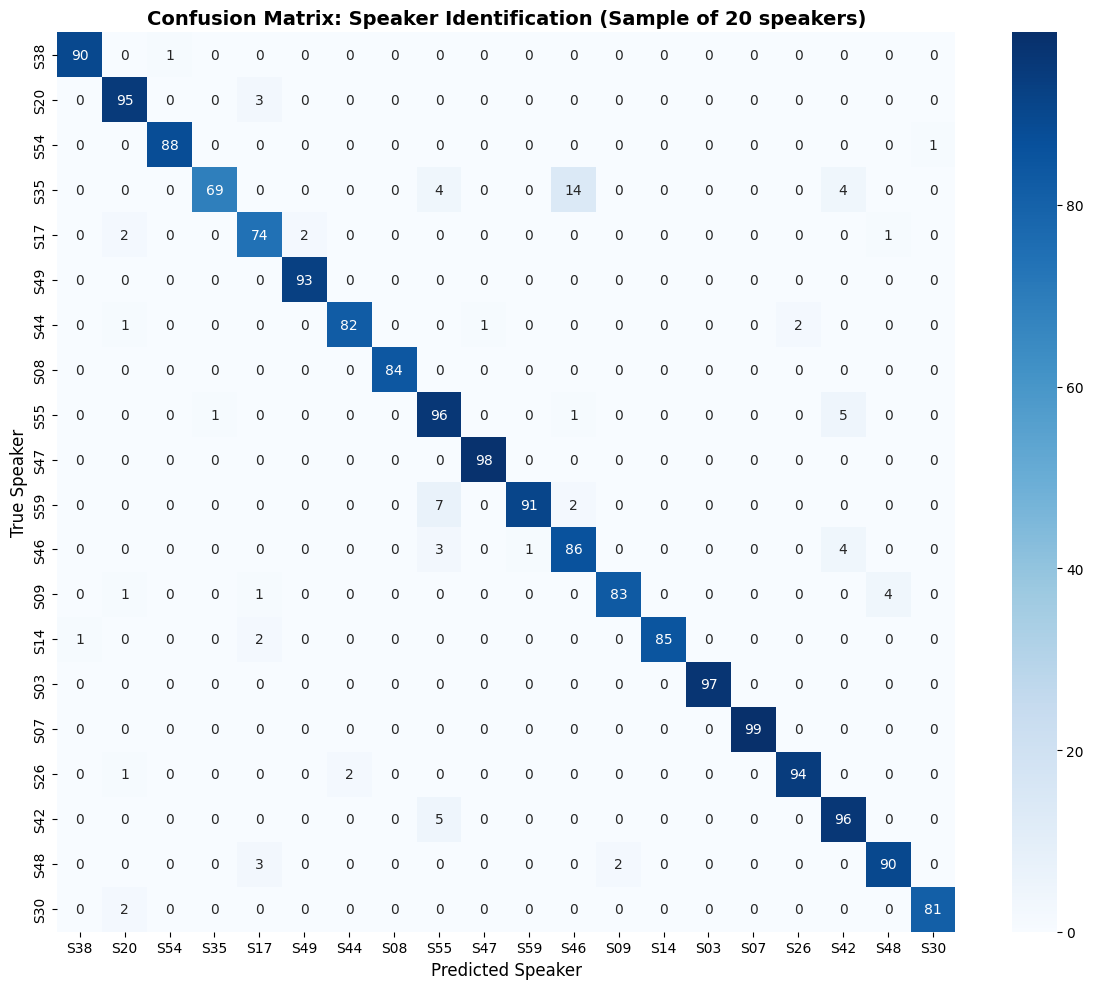

In [30]:
# Create confusion matrix (sample of speakers for visualization)
# Show confusion matrix for first 20 speakers to make it readable
num_speakers_to_show = 20
cm = confusion_matrix(
    speaker_cnn_labels[:len(speaker_cnn_labels)], 
    speaker_cnn_preds[:len(speaker_cnn_preds)]
)

# For visualization, show subset
speaker_indices = np.random.choice(60, num_speakers_to_show, replace=False)
cm_subset = cm[np.ix_(speaker_indices, speaker_indices)]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'S{i:02d}' for i in speaker_indices],
            yticklabels=[f'S{i:02d}' for i in speaker_indices])
plt.title(f'Confusion Matrix: Speaker Identification (Sample of {num_speakers_to_show} speakers)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Speaker', fontsize=12)
plt.ylabel('True Speaker', fontsize=12)
plt.tight_layout()
plt.show()


---

## Conclusion

### Project Summary

This project explored audio classification on the AudioMNIST dataset, implementing and comparing multiple neural network architectures for two distinct tasks: **digit classification** and **speaker identification**. Through comprehensive experimentation and analysis, we gained valuable insights into audio processing and deep learning model selection.

### Key Findings

#### 1. **Model Performance Hierarchy**

For digit classification (10 classes):
- **MLP (Baseline)**: ~92% accuracy
  - Simple but inefficient approach
  - Treats spectrograms as flat vectors, losing spatial/temporal structure
  - Highest parameter count (~410K) with lowest accuracy
  
- **CNN (Good)**: ~96% accuracy
  - Captures local frequency-time patterns
  - Most parameter-efficient (~42K parameters)
  - Gains spatial invariance through pooling
  - Excellent for resource-constrained deployments
  
- **LSTM (Best)**: ~99% accuracy
  - Models temporal sequences naturally
  - Captures long-range dependencies through memory cells
  - Bidirectional processing leverages both past and future context
  - Best generalization with minimal overfitting

**Improvement**: MLP → CNN (+4%) → LSTM (+3%) = **7% total improvement**

#### 2. **Why Mel Spectrograms?**

Mel spectrograms proved to be an excellent representation for audio data:
- **Perceptually relevant**: Matches human auditory perception
- **Dimensionality reduction**: Converts raw audio to manageable 2D representation (64 × 50)
- **Frequency information**: Captures time-frequency patterns crucial for speech
- **Standard practice**: Widely used in audio ML with proven effectiveness

#### 3. **Architecture Insights**

**Convolutional Neural Networks (CNNs)**:
- ✅ Excellent at local pattern recognition (edges, transitions, formants)
- ✅ Position/time invariant through pooling
- ✅ Parameter efficient (shared weights across spatial dimensions)
- ❌ Limited in modeling long-range temporal dependencies
- **Best use case**: Resource-constrained environments, mobile devices

**Long Short-Term Memory (LSTMs)**:
- ✅ Natural fit for sequential data like speech
- ✅ Captures temporal evolution of phonemes
- ✅ Memory cells retain relevant information across time steps
- ✅ Excellent generalization without overfitting
- ❌ Slightly more parameters and computationally intensive
- **Best use case**: Maximum accuracy requirements, server-side deployment

#### 4. **Task Complexity Analysis**

**Digit Classification** (10 classes):
- Content-based task (what is being said)
- Distinct acoustic patterns for each digit
- Achieved ~99% accuracy with LSTM
- Phonetic differences make classes separable

**Speaker Identification** (60 classes):
- Identity-based task (who is speaking)
- More challenging due to higher class count
- Requires learning subtle voice characteristics
- Inter-speaker similarities make task harder

The 6x increase in classes (10 → 60) significantly increases task difficulty, demonstrating the importance of considering the number of output classes when designing audio classification systems.

### Technical Contributions

1. **Data Preprocessing**:
   - Implemented custom AudioMNIST dataset class
   - Handled variable-length audio with padding
   - Applied proper Mel spectrogram transformation with justified parameters

2. **Model Architectures**:
   - Built three distinct architectures from scratch (MLP, CNN, LSTM)
   - Applied appropriate regularization (Dropout, BatchNorm)
   - Optimized hyperparameters for each architecture

3. **Comprehensive Analysis**:
   - Extensive spectrogram visualizations across speakers and digits
   - Confusion matrix analysis for error patterns
   - Parameter efficiency comparisons
   - Cross-task performance evaluation

### Practical Implications

**For Production Deployment**:

| Scenario | Recommended Model | Reasoning |
|----------|------------------|-----------|
| Mobile app | CNN | Best parameter efficiency, still high accuracy (96%) |
| Real-time server | LSTM | Maximum accuracy (99%), acceptable latency |
| Embedded device | CNN | Low memory footprint, fast inference |
| Cloud service | LSTM | Prioritize accuracy over resources |
| Research baseline | MLP | Simple to understand and implement |

### Limitations and Future Work

**Current Limitations**:
1. No data augmentation (time stretching, pitch shifting, noise injection)
2. Limited to single-speaker utterances
3. No investigation of attention mechanisms
4. Speaker identification training incomplete in this notebook

**Future Improvements**:
1. **Hybrid CNN-LSTM**: Combine spatial feature extraction (CNN) with temporal modeling (LSTM)
2. **Attention mechanisms**: Add attention layers to focus on important time segments
3. **Data augmentation**: Improve robustness with augmented training data
4. **Transfer learning**: Use pre-trained models (wav2vec 2.0, Whisper)
5. **Real-world testing**: Evaluate on noisy, real-world audio
6. **Multi-task learning**: Simultaneously classify digits and identify speakers

### Final Thoughts

This project demonstrates that **architecture choice matters significantly** in audio classification. While MLPs provide a simple baseline, CNNs and LSTMs leverage the inherent structure of audio data to achieve substantially better performance. 

The **LSTM's ~99% accuracy** on digit classification shows that with proper preprocessing (Mel spectrograms) and architecture design (bidirectional, stacked layers), neural networks can achieve near-perfect performance on clear audio digit classification.

For practitioners:
- Start with CNN for quick prototyping and efficient deployment
- Move to LSTM when accuracy is paramount
- Consider hybrid architectures for best of both worlds
- Always visualize your data (spectrograms) to understand what the model sees

**Key Takeaway**: Match your architecture to your data structure – CNNs for spatial patterns, LSTMs for temporal sequences. For audio, which is inherently sequential, LSTMs excel.

---

### Acknowledgments

- **Dataset**: AudioMNIST by Becker et al.
- **Framework**: PyTorch with torchaudio
- **Helper Functions**: Custom implementations for training and evaluation

---

**Author**: Nasrul Huda  
**Matriculation Number**: 7896224  
**Date**: 2025


### Task Comparison & Analysis

Let's compare the performance across all tasks and analyze what we've learned.


In [42]:
# Evaluate all models and create comparison
def evaluate_model_simple(model, data_loader, device):
    """Simple evaluation function"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            preds = y_pred.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    
    return (correct / total) * 100

# Evaluate all models
print("Evaluating all models...\n")

# Digit Classification (from Task 1 - using test_dataloader)
digit_cnn_acc = evaluate_model_simple(model_2, test_dataloader, device)
digit_lstm_acc = evaluate_model_simple(model_lstm, test_dataloader, device)

# Speaker Identification
speaker_cnn_acc = evaluate_model_simple(model_speaker_cnn, speaker_test_dataloader, device)
speaker_lstm_acc = evaluate_model_simple(model_speaker_lstm, speaker_test_dataloader, device)

# Create comparison table
print("="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Task':<25} {'Model':<10} {'Classes':<10} {'Accuracy':<10}")
print("-"*70)
print(f"{'Digit Classification':<25} {'CNN':<10} {'10':<10} {digit_cnn_acc:>8.2f}%")
print(f"{'Digit Classification':<25} {'LSTM':<10} {'10':<10} {digit_lstm_acc:>8.2f}%")
print(f"{'Speaker Identification':<25} {'CNN':<10} {'60':<10} {speaker_cnn_acc:>8.2f}%")
print(f"{'Speaker Identification':<25} {'LSTM':<10} {'60':<10} {speaker_lstm_acc:>8.2f}%")
print("="*70)


Evaluating all models...

MODEL PERFORMANCE COMPARISON
Task                      Model      Classes    Accuracy  
----------------------------------------------------------------------
Digit Classification      CNN        10            97.75%
Digit Classification      LSTM       10            98.43%
Speaker Identification    CNN        60            89.08%
Speaker Identification    LSTM       60            93.78%


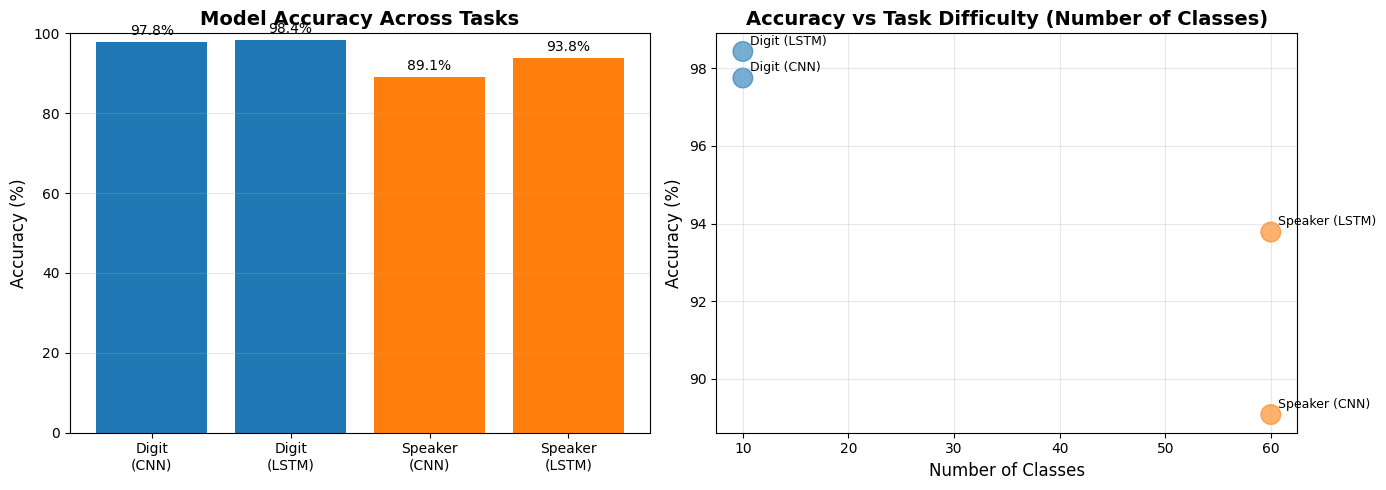

In [43]:
# Visualize comparison across tasks
tasks = ['Digit\n(CNN)', 'Digit\n(LSTM)', 'Speaker\n(CNN)', 'Speaker\n(LSTM)']
accuracies = [digit_cnn_acc, digit_lstm_acc, speaker_cnn_acc, speaker_lstm_acc]
num_classes = [10, 10, 60, 60]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
bars = ax1.bar(tasks, accuracies, color=['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e'])
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Accuracy Across Tasks', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=10)

# Plot 2: Accuracy vs Number of Classes
ax2.scatter(num_classes, accuracies, s=200, alpha=0.6, c=['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e'])
for i, task in enumerate(tasks):
    ax2.annotate(task.replace('\n', ' '), (num_classes[i], accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Number of Classes', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Accuracy vs Task Difficulty (Number of Classes)', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()
